In [1]:
%matplotlib inline
from pylab import *
import numpy as np
from craco.search_pipeline import location2pix, get_grid_lut_from_plan, grid_candidates,wait_for_starts,waitall,print_candidates
from craco.search_pipeline import NBINARY_POINT_FDMTIN 
import craco
import craco.search_pipeline
from craco.pyxrtutil import *
import craft.craco_plan

from craft import uvfits

from craft.craco_plan import PipelinePlan
from craft.craco import printstats
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("test")
import time


INFO:root:test


In [2]:
fits='/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits'
xclbin='/data/craco/ban115/builds/binary_container_1_10688715.xclbin'
#xclbin='/data/craco/ban115/builds/binary_container_01482863.xclbin'
alloc_device_only=True

In [3]:
values = craco.search_pipeline.get_parser().parse_args([])
print(values)

Namespace(boxcar_weight='sum', cand_file='candidates.txt', cell=None, device=0, dump_boxcar_hist_buf=None, dump_candidates=None, dump_fdmt_hist_buf=None, dump_mainbufs=None, dump_uvdata=None, fdmt_scale=1.0, fft_scale=10.0, fft_shift1=0, fft_shift2=7, input_scale=1.0, max_ndm=1024, nblocks=1, nbox=8, ncin=32, ndm=2, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', run_fdmt=True, run_image=True, show=False, show_candidate_grid=None, threshold=10.0, uv='frb_d0_lm0_nt16_nant24.fits', verbose=False, wait=False, xclbin='binary_container_1.xclbin.golden')


In [4]:
device = pyxrt.device(1)
xbin = pyxrt.xclbin(xclbin)
uuid = device.load_xclbin(xbin)


In [5]:
f = uvfits.open(fits)
plan = PipelinePlan(f, "--ndm 2 --ndout 186")

INFO:root:Opening file /data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits
INFO:root:making Plan values=Namespace(boxcar_weight='sum', cell=None, fdmt_scale=1.0, fft_scale=10.0, max_ndm=1024, nbox=8, ncin=32, ndm=2, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', pickle_fname='pipeline.pickle', save=False, show=False, show_fdmt=False, show_image=False, threshold=3, uv='uv_data', verbose=False)
INFO:root:Nbl=190 Fch1=735499993.944000 foff=1000000.047500 nchan=256 lambdamin=0.302877 uvmax=(2914.412072271962, 3548.709136210335) max baseline=(0.882709355209954, 1.0748235581559127) resolution=[70.77407077 58.12389754]arcsec uvcell=[33.70193846 27.67804645] arcsec uvcell= (23.90728653035594, 29.110504632975406) lambda FoV=[2.39658229 1.96821664] deg oversampled=(2.1, 2.1)
INFO:root:Got Ncells=3838 uvcells


parsing values --ndm 2 --ndout 186


INFO:root:FDMT plan has ntotal=5272 of 659 runs with packing efficiency 0.727997. Grid read requires efficiency of > 0.643555 of NUV=8192. History size square=252992736 minimal=1356368 =0 256MB HBM banks
INFO:root:FDMT zero cell is (658, 2)=5266
INFO:root:Saving uvgrid.split shape=(5245, 14) type=float64 to uv_data.uvgrid.split.txt header=ant1, ant2, u(pix), v(pix), chan1, chan2, irun, icell, total_overlap, max_idm, max_offset, offset_cff, idm_cff, fch1
INFO:root:Got 3388 unique UV coords. Upper=True
INFO:root:Need to write 212 groups of 16 register to pad function
INFO:root:Got 3367 unique UV coords. Upper=False
INFO:root:Need to write 211 groups of 16 register to pad function
INFO:root:Got 5362 upper grid instructions
INFO:root:Saving gridlut.upper shape=(5362, 5) type=int32 to uv_data.gridlut.upper.txt header=target_slot, uvidx, shift_flag, upix, vpix
INFO:root:Got 5324 lower grid instructions
INFO:root:Saving gridlut.lower shape=(5324, 5) type=int32 to uv_data.gridlut.lower.txt hea

In [6]:
print(plan.ndout)

186


In [7]:
p = craco.search_pipeline.Pipeline(device, xbin, plan, alloc_device_only)

INFO:craco.search_pipeline:2636 2681 2662
INFO:craco.search_pipeline:(180214,)


Kernel krnl_ddgrid_reader_4cu:krnl_ddgrid_reader_4cu_1 has groups
GID=0=32
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=15
Kernel krnl_grid_4cu:krnl_grid_4cu_1 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=6
Kernel krnl_grid_4cu:krnl_grid_4cu_2 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=7
Kernel krnl_grid_4cu:krnl_grid_4cu_3 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=20
Kernel krnl_grid_4cu:krnl_grid_4cu_4 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=21
Kernel fft2d:fft2d_1 has groups
Kernel fft2d:fft2d_2 has groups
Kernel fft2d:fft2d_3 has groups
Kernel fft2d:fft2d_4 has groups

INFO:craco.search_pipeline:lut.shape (180214,)
INFO:craco.search_pipeline:nuv 5272
INFO:craco.search_pipeline:Allocating grid LUTs
INFO:craco.search_pipeline:Allocating FDMT Input
INFO:craco.search_pipeline:5272
INFO:craco.search_pipeline:256
INFO:craco.search_pipeline:32
INFO:craco.search_pipeline:8
INFO:craco.search_pipeline:659
INFO:craco.search_pipeline:186
INFO:craco.search_pipeline:FDMT input buffer size 164.75 MB
INFO:craco.search_pipeline:Allocating FDMT history



Kernel krnl_boxc_4cu:krnl_boxc_4cu_1 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=54
GID=4=54
GID=5=4
Kernel fdmt_tunable_c32:fdmt_tunable_c32_1 has groups
GID=0=52
GID=1=32
GID=2=53
GID=3=53
GID=4=14
Allocated 360428 bytes flags=flags.normal groupid=6 address=0x60000000
Allocated 360428 bytes flags=flags.normal groupid=7 address=0x70000000
Allocated 360428 bytes flags=flags.normal groupid=20 address=0x140000000
Allocated 360428 bytes flags=flags.normal groupid=21 address=0x150000000
Allocated 172752896 bytes flags=flags.normal groupid=52 address=0x90000000
Allocated 268435456 bytes flags=flags.normal groupid=53 address=0xa0000000


INFO:craco.search_pipeline:Allocating mainbuf
INFO:craco.search_pipeline:FDMT output buffer size 10.286819458007812 GB
INFO:root:Mainbuf shape is (659, 186, 11, 256, 8, 2) breaking into 8 buffers of [83, 186, 11, 256, 8, 2]


Allocated 653728 bytes flags=flags.normal groupid=14 address=0xe0000000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x4000000000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x4052eb4000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x40a5d68000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x40f8c1c000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x414bad0000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x419e984000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x41f1838000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x42446ec000


INFO:craco.search_pipeline:Allocating ddreader_lut
INFO:craco.search_pipeline:Allocating boxcar_history


Allocated 8192 bytes flags=flags.normal groupid=15 address=0xf0000000
Allocated 1073741824 bytes flags=flags.normal groupid=54 address=0x0


INFO:craco.search_pipeline:Allocating candidates


Boxcar history (1024, 8, 256, 256) 1073741824 2
Allocated 1048576 bytes flags=flags.normal groupid=4 address=0x40000000


In [8]:
p.fdmtcu.krnl.read_register(0x00)

4

In [9]:
# check clearing buffers a lot doesn't lockup
print(values)
for i in range(100):
    print('Clearing', i)
#    p.clear_buffers(values)
    p.run(i % 11, values).wait()
    #time.sleep(0.1)
    

INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Namespace(boxcar_weight='sum', cand_file='candidates.txt', cell=None, device=0, dump_boxcar_hist_buf=None, dump_candidates=None, dump_fdmt_hist_buf=None, dump_mainbufs=None, dump_uvdata=None, fdmt_scale=1.0, fft_scale=10.0, fft_shift1=0, fft_shift2=7, input_scale=1.0, max_ndm=1024, nblocks=1, nbox=8, ncin=32, ndm=2, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', run_fdmt=True, run_image=True, show=False, show_candidate_grid=None, threshold=10.0, uv='frb_d0_lm0_nt16_nant24.fits', verbose=False, wait=False, xclbin='binary_container_1.xclbin.golden')
Clearing 0


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Call: 1.0744915430259425 Wait:0.0012073389953002334: Total:1.0756988820212428
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929271f0>
INFO:craco.search_pipeline:Call: 1.0744915430259425 Wait:0.002770757972029969: Total:1.0772623009979725
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927378>
INFO:craco.search_pipeline:Call: 1.0744915430259425 Wait:0.004205454984912649: Total:1.0786969980108552
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pipeline:Call: 1.0744915430259425 Wait:0.006345315981889144: Total:1.0808368590078317
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pip

Clearing 1


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:Call: 1.0773043170047458 Wait:0.0014940359978936613: Total:1.0787983530026395
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927378>
INFO:craco.search_pipeline:Call: 1.0773043170047458 Wait:0.003589611005736515: Total:1.0808939280104823
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.0773043170047458 Wait:0.005199295992497355: Total:1.0825036129972432
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929273e8>
INFO:craco.search_pipeline:Call: 1.0773043170047458 Wait:0.006924621993675828: Total:1.0842289389984217
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pip

Clearing 2



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f8192927378>
INFO:craco.search_pipeline:Call: 1.0774981660069898 Wait:0.0012401209969539195: Total:1.0787382870039437
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929274c8>
INFO:craco.search_pipeline:Call: 1.0774981660069898 Wait:0.0023970939801074564: Total:1.0798952599870972
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pipeline:Call: 1.0774981660069898 Wait:0.0034392689995002: Total:1.08093743500649
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927490>
INFO:craco.search_pipeline:Call: 1.0774981660069898 Wait:0.0051588489732239395: Total:1.0826570149802137
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pipe

Clearing 3



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.075189555005636 Wait:0.00127277200226672: Total:1.0764623270079028
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pipeline:Call: 1.075189555005636 Wait:0.0030562350002583116: Total:1.0782457900058944
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929271f0>
INFO:craco.search_pipeline:Call: 1.075189555005636 Wait:0.0046276850043796: Total:1.0798172400100157
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pipeline:Call: 1.075189555005636 Wait:0.006119387981016189: Total:1.0813089429866523
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_pipeline:

Clearing 4



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0761745509807952 Wait:0.0016268250183202326: Total:1.0778013759991154
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeline:Call: 1.0761745509807952 Wait:0.003514814015943557: Total:1.0796893649967387
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.0761745509807952 Wait:0.005154156009666622: Total:1.0813287069904618
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929271b8>
INFO:craco.search_pipeline:Call: 1.0761745509807952 Wait:0.006728861015290022: Total:1.0829034119960852
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pi

Clearing 5



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0762509249907453 Wait:0.001250208995770663: Total:1.077501133986516
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927490>
INFO:craco.search_pipeline:Call: 1.0762509249907453 Wait:0.003011043998412788: Total:1.079261968989158
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_pipeline:Call: 1.0762509249907453 Wait:0.004616308986442164: Total:1.0808672339771874
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Call: 1.0762509249907453 Wait:0.0063519260147586465: Total:1.082602851005504
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pipel

Clearing 6


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0759598019940313 Wait:0.0016158929793164134: Total:1.0775756949733477
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Call: 1.0759598019940313 Wait:0.0035424410016275942: Total:1.079502242995659
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pipeline:Call: 1.0759598019940313 Wait:0.005180765991099179: Total:1.0811405679851305
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:Call: 1.0759598019940313 Wait:0.006730310997227207: Total:1.0826901129912585
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929274c8>
INFO:craco.search_pip

Clearing 7


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0835553770011757 Wait:0.0019454199937172234: Total:1.0855007969948929
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927378>
INFO:craco.search_pipeline:Call: 1.0835553770011757 Wait:0.0037344640004448593: Total:1.0872898410016205
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pipeline:Call: 1.0835553770011757 Wait:0.005277044983813539: Total:1.0888324219849892
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pipeline:Call: 1.0835553770011757 Wait:0.006802298012189567: Total:1.0903576750133652
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pi

Clearing 8


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.076288406009553 Wait:0.0015933440008666366: Total:1.0778817500104196
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pipeline:Call: 1.076288406009553 Wait:0.0036616130091715604: Total:1.0799500190187246
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_pipeline:Call: 1.076288406009553 Wait:0.005430365010397509: Total:1.0817187710199505
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_pipeline:Call: 1.076288406009553 Wait:0.009049598011188209: Total:1.0853380040207412
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929273e8>
INFO:craco.search_pipeli

Clearing 9


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0732327960140537 Wait:0.0020182779990136623: Total:1.0752510740130674
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pipeline:Call: 1.0732327960140537 Wait:0.003745502996025607: Total:1.0769782990100794
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929274c8>
INFO:craco.search_pipeline:Call: 1.0732327960140537 Wait:0.005388953984947875: Total:1.0786217499990016
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927490>
INFO:craco.search_pipeline:Call: 1.0732327960140537 Wait:0.0069199479767121375: Total:1.0801527439907659
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pi

Clearing 10


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0774188509967644 Wait:0.0013640529941767454: Total:1.0787829039909411
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929273e8>
INFO:craco.search_pipeline:Call: 1.0774188509967644 Wait:0.0029848350095562637: Total:1.0804036860063206
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.0774188509967644 Wait:0.004504310985794291: Total:1.0819231619825587
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:Call: 1.0774188509967644 Wait:0.005937011999776587: Total:1.083355862996541
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pip

Clearing 11


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0772197670012247 Wait:0.0012796680093742907: Total:1.078499435010599
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927378>
INFO:craco.search_pipeline:Call: 1.0772197670012247 Wait:0.002946174005046487: Total:1.0801659410062712
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Call: 1.0772197670012247 Wait:0.004541964997770265: Total:1.081761731998995
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeline:Call: 1.0772197670012247 Wait:0.006556851003551856: Total:1.0837766180047765
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_pipel

Clearing 12



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0833576589939184 Wait:0.001441825006622821: Total:1.0847994840005413
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pipeline:Call: 1.0833576589939184 Wait:0.0032058640208560973: Total:1.0865635230147745
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pipeline:Call: 1.0833576589939184 Wait:0.004738593997899443: Total:1.088096252991818
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_pipeline:Call: 1.0833576589939184 Wait:0.006214768014615402: Total:1.0895724270085339
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929274c8>
INFO:craco.search_pip

Clearing 13


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0740454570041038 Wait:0.0019277080136816949: Total:1.0759731650177855
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pipeline:Call: 1.0740454570041038 Wait:0.003646983008366078: Total:1.0776924400124699
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pipeline:Call: 1.0740454570041038 Wait:0.005357841000659391: Total:1.0794032980047632
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927490>
INFO:craco.search_pipeline:Call: 1.0740454570041038 Wait:0.006858128006570041: Total:1.0809035850106739
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pip

Clearing 14


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0813353440025821 Wait:0.0014585160242859274: Total:1.082793860026868
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929274c8>
INFO:craco.search_pipeline:Call: 1.0813353440025821 Wait:0.0033244530204683542: Total:1.0846597970230505
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929271f0>
INFO:craco.search_pipeline:Call: 1.0813353440025821 Wait:0.004859659005887806: Total:1.08619500300847
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:Call: 1.0813353440025821 Wait:0.006361516017932445: Total:1.0876968600205146
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipel

Clearing 15



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0771456090151332 Wait:0.0012381940032355487: Total:1.0783838030183688
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:Call: 1.0771456090151332 Wait:0.0030136359855532646: Total:1.0801592450006865
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929271b8>
INFO:craco.search_pipeline:Call: 1.0771456090151332 Wait:0.004572509991703555: Total:1.0817181190068368
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeline:Call: 1.0771456090151332 Wait:0.006118363991845399: Total:1.0832639730069786
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_p

Clearing 16


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0762044680013787 Wait:0.0014473710034508258: Total:1.0776518390048295
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeline:Call: 1.0762044680013787 Wait:0.003202487016096711: Total:1.0794069550174754
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pipeline:Call: 1.0762044680013787 Wait:0.004636268015019596: Total:1.0808407360163983
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_pipeline:Call: 1.0762044680013787 Wait:0.006020395027007908: Total:1.0822248630283866
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pip

Clearing 17


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0771010530006606 Wait:0.0014944750000722706: Total:1.0785955280007329
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929274c8>
INFO:craco.search_pipeline:Call: 1.0771010530006606 Wait:0.0033805690181907266: Total:1.0804816220188513
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pipeline:Call: 1.0771010530006606 Wait:0.0049565549998078495: Total:1.0820576080004685
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927490>
INFO:craco.search_pipeline:Call: 1.0771010530006606 Wait:0.0064751890022307634: Total:1.0835762420028914
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_

Clearing 18



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0834492040157784 Wait:0.0014901039830874652: Total:1.0849393079988658
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929271f0>
INFO:craco.search_pipeline:Call: 1.0834492040157784 Wait:0.003333581000333652: Total:1.086782785016112
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Call: 1.0834492040157784 Wait:0.005003172991564497: Total:1.0884523770073429
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.0834492040157784 Wait:0.006583647977095097: Total:1.0900328519928735
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929271b8>
INFO:craco.search_pip

Clearing 19


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0782774630060885 Wait:0.0015519709850195795: Total:1.079829433991108
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929273e8>
INFO:craco.search_pipeline:Call: 1.0782774630060885 Wait:0.0036306509864516556: Total:1.0819081139925402
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:Call: 1.0782774630060885 Wait:0.005328013008693233: Total:1.0836054760147817
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pipeline:Call: 1.0782774630060885 Wait:0.006968197994865477: Total:1.085245661000954
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pipe

Clearing 20



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.075508850015467 Wait:0.0014011869789101183: Total:1.0769100369943772
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929271b8>
INFO:craco.search_pipeline:Call: 1.075508850015467 Wait:0.0032958439842332155: Total:1.0788046939997002
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927490>
INFO:craco.search_pipeline:Call: 1.075508850015467 Wait:0.004769725986989215: Total:1.0802785760024562
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pipeline:Call: 1.075508850015467 Wait:0.006154767994303256: Total:1.0816636180097703
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pipel

Clearing 21


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0772160000051372 Wait:0.0014877700014039874: Total:1.0787037700065412
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pipeline:Call: 1.0772160000051372 Wait:0.0034245749993715435: Total:1.0806405750045087
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927490>
INFO:craco.search_pipeline:Call: 1.0772160000051372 Wait:0.004994249000446871: Total:1.082210249005584
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.0772160000051372 Wait:0.006543935014633462: Total:1.0837599350197706
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pip

Clearing 22


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0775271310121752 Wait:0.001499281992437318: Total:1.0790264130046126
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.0775271310121752 Wait:0.003201126994099468: Total:1.0807282580062747
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929273e8>
INFO:craco.search_pipeline:Call: 1.0775271310121752 Wait:0.004710357985459268: Total:1.0822374889976345
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeline:Call: 1.0775271310121752 Wait:0.00617291999515146: Total:1.0837000510073267
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929271f0>
INFO:craco.search_pipel

Clearing 23


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0764841390191577 Wait:0.0011846509878523648: Total:1.07766879000701
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeline:Call: 1.0764841390191577 Wait:0.002234832994872704: Total:1.0787189720140304
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pipeline:Call: 1.0764841390191577 Wait:0.0031164199754130095: Total:1.0796005589945707
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_pipeline:Call: 1.0764841390191577 Wait:0.003962982998928055: Total:1.0804471220180858
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pipe

Clearing 24


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.074969212000724 Wait:0.0017431789892725646: Total:1.0767123909899965
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pipeline:Call: 1.074969212000724 Wait:0.0034457820001989603: Total:1.0784149940009229
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929271b8>
INFO:craco.search_pipeline:Call: 1.074969212000724 Wait:0.004893178993370384: Total:1.0798623909940943
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927378>
INFO:craco.search_pipeline:Call: 1.074969212000724 Wait:0.006269542995141819: Total:1.0812387549958657
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927490>
INFO:craco.search_pipeli

Clearing 25


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.080858238012297 Wait:0.001555264985654503: Total:1.0824135029979516
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927378>
INFO:craco.search_pipeline:Call: 1.080858238012297 Wait:0.003316449001431465: Total:1.0841746870137285
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pipeline:Call: 1.080858238012297 Wait:0.004761023010360077: Total:1.0856192610226572
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Call: 1.080858238012297 Wait:0.006137682008557022: Total:1.086995920020854
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929273e8>
INFO:craco.search_pipeline:

Clearing 26


INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.076888974988833 Wait:0.0013339899887796491: Total:1.0782229649776127
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Call: 1.076888974988833 Wait:0.0031220770033542067: Total:1.0800110519921873
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:Call: 1.076888974988833 Wait:0.00445609400048852: Total:1.0813450689893216
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.076888974988833 Wait:0.005767249997006729: Total:1.0826562249858398
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927500>
I

Clearing 27


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0767637340177316 Wait:0.0013317679986357689: Total:1.0780955020163674
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pipeline:Call: 1.0767637340177316 Wait:0.003151391982100904: Total:1.0799151259998325
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeline:Call: 1.0767637340177316 Wait:0.004728972999146208: Total:1.0814927070168778
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_pipeline:Call: 1.0767637340177316 Wait:0.006232469982933253: Total:1.0829962040006649
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929271b8>
INFO:craco.search_pip

Clearing 28


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0759125920012593 Wait:0.001435571990441531: Total:1.0773481639917009
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_pipeline:Call: 1.0759125920012593 Wait:0.003105404000962153: Total:1.0790179960022215
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929271f0>
INFO:craco.search_pipeline:Call: 1.0759125920012593 Wait:0.004672438983106986: Total:1.0805850309843663
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927490>
INFO:craco.search_pipeline:Call: 1.0759125920012593 Wait:0.006251398997846991: Total:1.0821639909991063
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929274c8>
INFO:craco.search_pipe

Clearing 29



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.077818240999477 Wait:0.0011609949870035052: Total:1.0789792359864805
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pipeline:Call: 1.077818240999477 Wait:0.0028103929944336414: Total:1.0806286339939106
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_pipeline:Call: 1.077818240999477 Wait:0.00431737897451967: Total:1.0821356199739967
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929273e8>
INFO:craco.search_pipeline:Call: 1.077818240999477 Wait:0.005787678994238377: Total:1.0836059199937154
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeli

Clearing 30


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0753969560028054 Wait:0.001143155008321628: Total:1.076540111011127
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929273e8>
INFO:craco.search_pipeline:Call: 1.0753969560028054 Wait:0.002458653994835913: Total:1.0778556099976413
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Call: 1.0753969560028054 Wait:0.0036430930194910616: Total:1.0790400490222964
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.0753969560028054 Wait:0.004819402995053679: Total:1.080216358997859
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipel

Clearing 31



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0785219850076828 Wait:0.0014703029883094132: Total:1.0799922879959922
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pipeline:Call: 1.0785219850076828 Wait:0.003130252007395029: Total:1.0816522370150778
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pipeline:Call: 1.0785219850076828 Wait:0.004873480997048318: Total:1.0833954660047311
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929271b8>
INFO:craco.search_pipeline:Call: 1.0785219850076828 Wait:0.00645560200791806: Total:1.0849775870156009
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pip

Clearing 32


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.076877820014488 Wait:0.0015006070025265217: Total:1.0783784270170145
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeline:Call: 1.076877820014488 Wait:0.0036920470010954887: Total:1.0805698670155834
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_pipeline:Call: 1.076877820014488 Wait:0.005502940010046586: Total:1.0823807600245345
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927490>
INFO:craco.search_pipeline:Call: 1.076877820014488 Wait:0.006883346009999514: Total:1.0837611660244875
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_pipeli

Clearing 33



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.07716981502017 Wait:0.0015066360065247864: Total:1.0786764510266948
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929271f0>
INFO:craco.search_pipeline:Call: 1.07716981502017 Wait:0.0035724149784073234: Total:1.0807422299985774
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927378>
INFO:craco.search_pipeline:Call: 1.07716981502017 Wait:0.005268410983262584: Total:1.0824382260034326
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:Call: 1.07716981502017 Wait:0.007091062987456098: Total:1.0842608780076262
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:

Clearing 34


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0770426140225027 Wait:0.0012707339774351567: Total:1.0783133479999378
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pipeline:Call: 1.0770426140225027 Wait:0.003273105976404622: Total:1.0803157199989073
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pipeline:Call: 1.0770426140225027 Wait:0.0048614550032652915: Total:1.081904069025768
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.0770426140225027 Wait:0.0064049119828268886: Total:1.0834475260053296
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pi

Clearing 35


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.073321991978446 Wait:0.0014625870098825544: Total:1.0747845789883286
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Call: 1.073321991978446 Wait:0.0033929340133909136: Total:1.076714925991837
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pipeline:Call: 1.073321991978446 Wait:0.004998657997930422: Total:1.0783206499763764
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929271b8>
INFO:craco.search_pipeline:Call: 1.073321991978446 Wait:0.006410096015315503: Total:1.0797320879937615
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_pipelin

Clearing 36


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0759226889931597 Wait:0.0019311720097903162: Total:1.07785386100295
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pipeline:Call: 1.0759226889931597 Wait:0.003737459017429501: Total:1.0796601480105892
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pipeline:Call: 1.0759226889931597 Wait:0.00524298902018927: Total:1.081165678013349
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927490>
INFO:craco.search_pipeline:Call: 1.0759226889931597 Wait:0.0067509899963624775: Total:1.0826736789895222
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927378>
INFO:craco.search_pipeli

Clearing 37



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0755729919765145 Wait:0.001437291008187458: Total:1.077010282984702
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_pipeline:Call: 1.0755729919765145 Wait:0.0032736870052758604: Total:1.0788466789817903
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeline:Call: 1.0755729919765145 Wait:0.0047948050196282566: Total:1.0803677969961427
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:Call: 1.0755729919765145 Wait:0.006267607997870073: Total:1.0818405999743845
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pi

Clearing 38


INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pipeline:Call: 1.0777776050090324 Wait:0.0014847049897070974: Total:1.0792623099987395
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeline:Call: 1.0777776050090324 Wait:0.0034957019961439073: Total:1.0812733070051763
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:Call: 1.0777776050090324 Wait:0.005408465978689492: Total:1.083186070987722
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.0777776050090324 Wait:0.007309280976187438: Total:1.0850868859852199
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929273e

Clearing 39


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0767630029877182 Wait:0.0021621510095428675: Total:1.078925153997261
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:Call: 1.0767630029877182 Wait:0.004022903012810275: Total:1.0807859060005285
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Call: 1.0767630029877182 Wait:0.005685676005668938: Total:1.0824486789933871
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929273e8>
INFO:craco.search_pipeline:Call: 1.0767630029877182 Wait:0.007220233004773036: Total:1.0839832359924912
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929271b8>
INFO:craco.search_pipe

Clearing 40


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0764322020113468 Wait:0.0014849919825792313: Total:1.077917193993926
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929273e8>
INFO:craco.search_pipeline:Call: 1.0764322020113468 Wait:0.0033842189877759665: Total:1.0798164209991228
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pipeline:Call: 1.0764322020113468 Wait:0.0049153709842357785: Total:1.0813475729955826
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929271f0>
INFO:craco.search_pipeline:Call: 1.0764322020113468 Wait:0.006451566005125642: Total:1.0828837680164725
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927490>
INFO:craco.search_pi

Clearing 41


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0741042740119155 Wait:0.0013750589860137552: Total:1.0754793329979293
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929271f0>
INFO:craco.search_pipeline:Call: 1.0741042740119155 Wait:0.0032097899820655584: Total:1.077314063993981
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929274c8>
INFO:craco.search_pipeline:Call: 1.0741042740119155 Wait:0.004898110986687243: Total:1.0790023849986028
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927378>
INFO:craco.search_pipeline:Call: 1.0741042740119155 Wait:0.006550499994773418: Total:1.080654774006689
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipe

Clearing 42


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0844147310126573 Wait:0.0012064790062140673: Total:1.0856212100188714
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_pipeline:Call: 1.0844147310126573 Wait:0.0031589980062562972: Total:1.0875737290189136
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pipeline:Call: 1.0844147310126573 Wait:0.005088890000479296: Total:1.0895036210131366
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.0844147310126573 Wait:0.00698469701455906: Total:1.0913994280272163
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pip

Clearing 43


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0745477349846624 Wait:0.0011004410043824464: Total:1.0756481759890448
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Call: 1.0745477349846624 Wait:0.0026616860122885555: Total:1.077209420996951
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeline:Call: 1.0745477349846624 Wait:0.004114798997761682: Total:1.078662533982424
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929271b8>
INFO:craco.search_pipeline:Call: 1.0745477349846624 Wait:0.005507683992618695: Total:1.080055418977281
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pipel

Clearing 44



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0746121010161005 Wait:0.0013669710024259984: Total:1.0759790720185265
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.0746121010161005 Wait:0.003043903998332098: Total:1.0776560050144326
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pipeline:Call: 1.0746121010161005 Wait:0.004539529996691272: Total:1.0791516310127918
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927490>
INFO:craco.search_pipeline:Call: 1.0746121010161005 Wait:0.005963303992757574: Total:1.080575405008858
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929274c8>
INFO:craco.search_pip

Clearing 45


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0765144820034038 Wait:0.0014238649746403098: Total:1.0779383469780441
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:Call: 1.0765144820034038 Wait:0.0032306499779224396: Total:1.0797451319813263
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pipeline:Call: 1.0765144820034038 Wait:0.004714423994300887: Total:1.0812289059977047
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927378>
INFO:craco.search_pipeline:Call: 1.0765144820034038 Wait:0.006196000991621986: Total:1.0827104829950258
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_pi

Clearing 46


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0736653319909237 Wait:0.0015527660143561661: Total:1.07521809800528
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929274c8>
INFO:craco.search_pipeline:Call: 1.0736653319909237 Wait:0.0033864370197989047: Total:1.0770517690107226
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_pipeline:Call: 1.0736653319909237 Wait:0.004962647013599053: Total:1.0786279790045228
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pipeline:Call: 1.0736653319909237 Wait:0.006246360018849373: Total:1.079911692009773
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipel

Clearing 47


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0726851409999654 Wait:0.0019178319780621678: Total:1.0746029729780275
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pipeline:Call: 1.0726851409999654 Wait:0.0036460359988268465: Total:1.0763311769987922
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_pipeline:Call: 1.0726851409999654 Wait:0.005193282995605841: Total:1.0778784239955712
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Call: 1.0726851409999654 Wait:0.006580512999789789: Total:1.0792656539997552
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pi

Clearing 48


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.078781793010421 Wait:0.0014624100003857166: Total:1.0802442030108068
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:Call: 1.078781793010421 Wait:0.00384432400460355: Total:1.0826261170150246
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pipeline:Call: 1.078781793010421 Wait:0.006314266996923834: Total:1.085096060007345
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927490>
INFO:craco.search_pipeline:Call: 1.078781793010421 Wait:0.008131855982355773: Total:1.0869136489927769
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pipeline:

Clearing 49


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0781362099805847 Wait:0.0014339410117827356: Total:1.0795701509923674
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929274c8>
INFO:craco.search_pipeline:Call: 1.0781362099805847 Wait:0.003266476996941492: Total:1.0814026869775262
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.0781362099805847 Wait:0.004830273013794795: Total:1.0829664829943795
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927378>
INFO:craco.search_pipeline:Call: 1.0781362099805847 Wait:0.006261519010877237: Total:1.084397728991462
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_pipe

Clearing 50


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0711521279881708 Wait:0.0012207760009914637: Total:1.0723729039891623
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_pipeline:Call: 1.0711521279881708 Wait:0.0027185950020793825: Total:1.0738707229902502
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929273e8>
INFO:craco.search_pipeline:Call: 1.0711521279881708 Wait:0.003862785000819713: Total:1.0750149129889905
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeline:Call: 1.0711521279881708 Wait:0.005012492008972913: Total:1.0761646199971437
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_pi

Clearing 51



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0720269859884866 Wait:0.0012747420114465058: Total:1.073301727999933
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:Call: 1.0720269859884866 Wait:0.003659465000964701: Total:1.0756864509894513
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pipeline:Call: 1.0720269859884866 Wait:0.006182520999573171: Total:1.0782095069880597
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Call: 1.0720269859884866 Wait:0.01173218002077192: Total:1.0837591660092585
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pipe

Clearing 52



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0767535580089316 Wait:0.0013312709925230592: Total:1.0780848290014546
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Call: 1.0767535580089316 Wait:0.0030513129895552993: Total:1.0798048709984869
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pipeline:Call: 1.0767535580089316 Wait:0.004640428989659995: Total:1.0813939869985916
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927490>
INFO:craco.search_pipeline:Call: 1.0767535580089316 Wait:0.006181503995321691: Total:1.0829350620042533
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_p

Clearing 53


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0767716099799145 Wait:0.001295615016715601: Total:1.07806722499663
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927490>
INFO:craco.search_pipeline:Call: 1.0767716099799145 Wait:0.003161646018270403: Total:1.079933255998185
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pipeline:Call: 1.0767716099799145 Wait:0.0047798900050111115: Total:1.0815514999849256
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929271b8>
INFO:craco.search_pipeline:Call: 1.0767716099799145 Wait:0.006422862003091723: Total:1.0831944719830062
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929273e8>
INFO:craco.search_pipeli

Clearing 54


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0776216890080832 Wait:0.001723661000141874: Total:1.079345350008225
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929274c8>
INFO:craco.search_pipeline:Call: 1.0776216890080832 Wait:0.0033267849939875305: Total:1.0809484740020707
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_pipeline:Call: 1.0776216890080832 Wait:0.0047576809884049: Total:1.082379369996488
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeline:Call: 1.0776216890080832 Wait:0.0059338069986552: Total:1.0835554960067384
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_pipeline:

Clearing 55


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0757597940100823 Wait:0.0011866179993376136: Total:1.0769464120094199
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeline:Call: 1.0757597940100823 Wait:0.0030197369924280792: Total:1.0787795310025103
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929271f0>
INFO:craco.search_pipeline:Call: 1.0757597940100823 Wait:0.004465692996745929: Total:1.0802254870068282
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pipeline:Call: 1.0757597940100823 Wait:0.0058707669959403574: Total:1.0816305610060226
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_p

Clearing 56



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0769361880084034 Wait:0.0012462690065149218: Total:1.0781824570149183
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929273e8>
INFO:craco.search_pipeline:Call: 1.0769361880084034 Wait:0.0031995030003599823: Total:1.0801356910087634
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:Call: 1.0769361880084034 Wait:0.004812255006982014: Total:1.0817484430153854
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.0769361880084034 Wait:0.006380817998433486: Total:1.083317006006837
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pi

Clearing 57


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0840160570223816 Wait:0.0013204359856899828: Total:1.0853364930080716
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.0840160570223816 Wait:0.0032579239923506975: Total:1.0872739810147323
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927378>
INFO:craco.search_pipeline:Call: 1.0840160570223816 Wait:0.004888191993813962: Total:1.0889042490161955
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929271b8>
INFO:craco.search_pipeline:Call: 1.0840160570223816 Wait:0.006503594981040806: Total:1.0905196520034224
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_pi

Clearing 58


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0815622129885014 Wait:0.0014960140106268227: Total:1.0830582269991282
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929271b8>
INFO:craco.search_pipeline:Call: 1.0815622129885014 Wait:0.0037734560028184205: Total:1.0853356689913198
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pipeline:Call: 1.0815622129885014 Wait:0.006127155007561669: Total:1.087689367996063
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_pipeline:Call: 1.0815622129885014 Wait:0.008463277015835047: Total:1.0900254900043365
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929271f0>
INFO:craco.search_pip

Clearing 59



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0775279040099122 Wait:0.001318883994827047: Total:1.0788467880047392
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_pipeline:Call: 1.0775279040099122 Wait:0.0032108489831443876: Total:1.0807387529930566
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pipeline:Call: 1.0775279040099122 Wait:0.004796430002897978: Total:1.0823243340128101
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pipeline:Call: 1.0775279040099122 Wait:0.006077662983443588: Total:1.0836055669933558
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pi

Clearing 60


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0776682539726608 Wait:0.0017275590216740966: Total:1.0793958129943348
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.0776682539726608 Wait:0.003332385007524863: Total:1.0810006389801856
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeline:Call: 1.0776682539726608 Wait:0.004731476015876979: Total:1.0823997299885377
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pipeline:Call: 1.0776682539726608 Wait:0.0061866970208939165: Total:1.0838549509935547
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927378>
INFO:craco.search_pi

Clearing 61


INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.082658077008091 Wait:0.0015789199969731271: Total:1.084236997005064
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pipeline:Call: 1.082658077008091 Wait:0.003462028020294383: Total:1.0861201050283853
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_pipeline:Call: 1.082658077008091 Wait:0.005082168005174026: Total:1.087740245013265
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Call: 1.082658077008091 Wait:0.006597719999263063: Total:1.089255797007354
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929273e8>
INFO

Clearing 62


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0750880929990672 Wait:0.001399626984493807: Total:1.076487719983561
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_pipeline:Call: 1.0750880929990672 Wait:0.003346364974277094: Total:1.0784344579733443
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929271b8>
INFO:craco.search_pipeline:Call: 1.0750880929990672 Wait:0.00497716898098588: Total:1.080065261980053
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pipeline:Call: 1.0750880929990672 Wait:0.0065306049946229905: Total:1.0816186979936901
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeli

Clearing 63


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0787775330245495 Wait:0.0018066329939756542: Total:1.0805841660185251
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.0787775330245495 Wait:0.0034070159890688956: Total:1.0821845490136184
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeline:Call: 1.0787775330245495 Wait:0.004845667979680002: Total:1.0836232010042295
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927490>
INFO:craco.search_pipeline:Call: 1.0787775330245495 Wait:0.006242076982744038: Total:1.0850196100072935
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929271f0>
INFO:craco.search_pi

Clearing 64



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0777876999927685 Wait:0.0016761209990363568: Total:1.0794638209918048
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929274c8>
INFO:craco.search_pipeline:Call: 1.0777876999927685 Wait:0.0034314570075366646: Total:1.0812191570003051
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pipeline:Call: 1.0777876999927685 Wait:0.0049869750218931586: Total:1.0827746750146616
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927378>
INFO:craco.search_pipeline:Call: 1.0777876999927685 Wait:0.006550354999490082: Total:1.0843380549922585
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_

Clearing 65



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.077636572998017 Wait:0.0018171289993915707: Total:1.0794537019974086
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927378>
INFO:craco.search_pipeline:Call: 1.077636572998017 Wait:0.0037591579894069582: Total:1.081395730987424
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929273e8>
INFO:craco.search_pipeline:Call: 1.077636572998017 Wait:0.005500768980709836: Total:1.083137341978727
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Call: 1.077636572998017 Wait:0.0071484049840364605: Total:1.0847849779820535
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929271b8>
INFO:craco.search_pipeli

Clearing 66


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0763395829999354 Wait:0.0016797499847598374: Total:1.0780193329846952
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929274c8>
INFO:craco.search_pipeline:Call: 1.0763395829999354 Wait:0.003595153975766152: Total:1.0799347369757015
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929271b8>
INFO:craco.search_pipeline:Call: 1.0763395829999354 Wait:0.005285648978315294: Total:1.0816252319782507
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_pipeline:Call: 1.0763395829999354 Wait:0.006896933977259323: Total:1.0832365169771947
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pip

Clearing 67



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0765554269892164 Wait:0.0012446320033632219: Total:1.0778000589925796
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.0765554269892164 Wait:0.0029504249978344887: Total:1.0795058519870508
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:Call: 1.0765554269892164 Wait:0.004473651002626866: Total:1.0810290779918432
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pipeline:Call: 1.0765554269892164 Wait:0.005995957006234676: Total:1.082551383995451
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927490>
INFO:craco.search_pi

Clearing 68


INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.076947992987698 Wait:0.001154819008661434: Total:1.0781028119963594
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:Call: 1.076947992987698 Wait:0.0028327640029601753: Total:1.0797807569906581
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927490>
INFO:craco.search_pipeline:Call: 1.076947992987698 Wait:0.0043653169996105134: Total:1.0813133099873085
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929271f0>
INFO:craco.search_pipeline:Call: 1.076947992987698 Wait:0.006045596994226798: Total:1.0829935899819247
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929273e8>


Clearing 69


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0767278200073633 Wait:0.0018875559908337891: Total:1.0786153759981971
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929274c8>
INFO:craco.search_pipeline:Call: 1.0767278200073633 Wait:0.0034782279981300235: Total:1.0802060480054934
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927378>
INFO:craco.search_pipeline:Call: 1.0767278200073633 Wait:0.00489628899958916: Total:1.0816241090069525
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Call: 1.0767278200073633 Wait:0.006399967998731881: Total:1.0831277880060952
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929271b8>
INFO:craco.search_pip

Clearing 70



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.074594067002181 Wait:0.0013432539999485016: Total:1.0759373210021295
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pipeline:Call: 1.074594067002181 Wait:0.0029503840196412057: Total:1.0775444510218222
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pipeline:Call: 1.074594067002181 Wait:0.004343437001807615: Total:1.0789375040039886
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_pipeline:Call: 1.074594067002181 Wait:0.00569964901660569: Total:1.0802937160187867
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeli

Clearing 71


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.080321305023972 Wait:0.001240858982782811: Total:1.0815621640067548
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeline:Call: 1.080321305023972 Wait:0.003087438002694398: Total:1.0834087430266663
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pipeline:Call: 1.080321305023972 Wait:0.0049697769863996655: Total:1.0852910820103716
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_pipeline:Call: 1.080321305023972 Wait:0.007843970990506932: Total:1.0881652760144789
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927490>
INFO:craco.search_pipelin

Clearing 72


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0752335180004593 Wait:0.001329046004684642: Total:1.076562564005144
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929274c8>
INFO:craco.search_pipeline:Call: 1.0752335180004593 Wait:0.00325360702117905: Total:1.0784871250216383
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pipeline:Call: 1.0752335180004593 Wait:0.005228709022048861: Total:1.0804622270225082
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929271f0>
INFO:craco.search_pipeline:Call: 1.0752335180004593 Wait:0.007133375009289011: Total:1.0823668930097483
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929273e8>
INFO:craco.search_pipeli

Clearing 73


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0782028260000516 Wait:0.0014349150005728006: Total:1.0796377410006244
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927378>
INFO:craco.search_pipeline:Call: 1.0782028260000516 Wait:0.0031619290239177644: Total:1.0813647550239693
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_pipeline:Call: 1.0782028260000516 Wait:0.004669751011533663: Total:1.0828725770115852
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Call: 1.0782028260000516 Wait:0.006097575998865068: Total:1.0843004019989166
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pi

Clearing 74


INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0780202240275685 Wait:0.0014493899943772703: Total:1.0794696140219457
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_pipeline:Call: 1.0780202240275685 Wait:0.0034921179758384824: Total:1.081512342003407
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pipeline:Call: 1.0780202240275685 Wait:0.00597850899794139: Total:1.0839987330255099
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pipeline:Call: 1.0780202240275685 Wait:0.008177218987839296: Total:1.0861974430154078
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927228

Clearing 75


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0769480429880787 Wait:0.0012546130164992064: Total:1.0782026560045779
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:Call: 1.0769480429880787 Wait:0.0031450710084754974: Total:1.0800931139965542
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeline:Call: 1.0769480429880787 Wait:0.004749075014842674: Total:1.0816971180029213
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_pipeline:Call: 1.0769480429880787 Wait:0.006320248998235911: Total:1.0832682919863146
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pi

Clearing 76


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0790004789887462 Wait:0.0012840480194427073: Total:1.0802845270081889
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pipeline:Call: 1.0790004789887462 Wait:0.0028505359950941056: Total:1.0818510149838403
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Call: 1.0790004789887462 Wait:0.004079873004229739: Total:1.083080351992976
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929271f0>
INFO:craco.search_pipeline:Call: 1.0790004789887462 Wait:0.005252122005913407: Total:1.0842526009946596
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pip

Clearing 77



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0773053689918015 Wait:0.0010963690001517534: Total:1.0784017379919533
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927378>
INFO:craco.search_pipeline:Call: 1.0773053689918015 Wait:0.0024620030017104: Total:1.079767371993512
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929274c8>
INFO:craco.search_pipeline:Call: 1.0773053689918015 Wait:0.00371146498946473: Total:1.0810168339812662
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929273e8>
INFO:craco.search_pipeline:Call: 1.0773053689918015 Wait:0.00489827900310047: Total:1.082203647994902
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pipeline

Clearing 78


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.076112523995107 Wait:0.001150333002442494: Total:1.0772628569975495
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929273e8>
INFO:craco.search_pipeline:Call: 1.076112523995107 Wait:0.002928873000200838: Total:1.0790413969953079
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929271b8>
INFO:craco.search_pipeline:Call: 1.076112523995107 Wait:0.004561909008771181: Total:1.0806744330038782
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pipeline:Call: 1.076112523995107 Wait:0.0061429009947460145: Total:1.082255424989853
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeline

Clearing 79


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0765628530061804 Wait:0.0011655279959086329: Total:1.077728381002089
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:Call: 1.0765628530061804 Wait:0.005815005977638066: Total:1.0823778589838184
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.0765628530061804 Wait:0.0077478579769376665: Total:1.084310710983118
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927490>
INFO:craco.search_pipeline:Call: 1.0765628530061804 Wait:0.009601350990124047: Total:1.0861642039963044
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipe

Clearing 80


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.076667978981277 Wait:0.002042453008471057: Total:1.078710431989748
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929273e8>
INFO:craco.search_pipeline:Call: 1.076667978981277 Wait:0.0038202909927349538: Total:1.080488269974012
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pipeline:Call: 1.076667978981277 Wait:0.005415215011453256: Total:1.0820831939927302
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929271f0>
INFO:craco.search_pipeline:Call: 1.076667978981277 Wait:0.007045128004392609: Total:1.0837131069856696
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929274c8>
INFO:craco.search_pipeline:

Clearing 81


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0759434020146728 Wait:0.0011057779775001109: Total:1.0770491799921729
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Call: 1.0759434020146728 Wait:0.002837081003235653: Total:1.0787804830179084
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pipeline:Call: 1.0759434020146728 Wait:0.004573921993141994: Total:1.0805173240078148
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pipeline:Call: 1.0759434020146728 Wait:0.006280325003899634: Total:1.0822237270185724
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929271b8>
INFO:craco.search_pip

Clearing 82


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0799525229958817 Wait:0.0014142039872240275: Total:1.0813667269831058
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pipeline:Call: 1.0799525229958817 Wait:0.0033879260008689016: Total:1.0833404489967506
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_pipeline:Call: 1.0799525229958817 Wait:0.005335030989954248: Total:1.085287553985836
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pipeline:Call: 1.0799525229958817 Wait:0.007241026993142441: Total:1.0871935499890242
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pip

Clearing 83


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.072844727023039 Wait:0.0010986169800162315: Total:1.0739433440030552
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_pipeline:Call: 1.072844727023039 Wait:0.0028280509868636727: Total:1.0756727780099027
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:Call: 1.072844727023039 Wait:0.004459379997570068: Total:1.077304107020609
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927490>
INFO:craco.search_pipeline:Call: 1.072844727023039 Wait:0.006067797978175804: Total:1.0789125250012148
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pipelin

Clearing 84



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.07811317499727 Wait:0.0017204370233230293: Total:1.0798336120205931
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929273e8>
INFO:craco.search_pipeline:Call: 1.07811317499727 Wait:0.003493099007755518: Total:1.0816062740050256
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeline:Call: 1.07811317499727 Wait:0.005094192019896582: Total:1.0832073670171667
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929271f0>
INFO:craco.search_pipeline:Call: 1.07811317499727 Wait:0.0066690829989966005: Total:1.0847822579962667
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pipeline:

Clearing 85


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0765792400052305 Wait:0.0016265150043182075: Total:1.0782057550095487
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pipeline:Call: 1.0765792400052305 Wait:0.0033081629953812808: Total:1.0798874030006118
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Call: 1.0765792400052305 Wait:0.004935848992317915: Total:1.0815150889975484
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929271b8>
INFO:craco.search_pipeline:Call: 1.0765792400052305 Wait:0.006584989983821288: Total:1.0831642299890518
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pi

Clearing 86


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0785318330163136 Wait:0.0014150769857224077: Total:1.079946910002036
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pipeline:Call: 1.0785318330163136 Wait:0.003184066998073831: Total:1.0817159000143874
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929274c8>
INFO:craco.search_pipeline:Call: 1.0785318330163136 Wait:0.00474028498865664: Total:1.0832721180049703
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:Call: 1.0785318330163136 Wait:0.0062537670019082725: Total:1.0847856000182219
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_pipe

Clearing 87


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0776254440133926 Wait:0.002149656997062266: Total:1.0797751010104548
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:Call: 1.0776254440133926 Wait:0.0038514260086230934: Total:1.0814768700220156
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927378>
INFO:craco.search_pipeline:Call: 1.0776254440133926 Wait:0.005436551000457257: Total:1.0830619950138498
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeline:Call: 1.0776254440133926 Wait:0.006937573984032497: Total:1.084563017997425
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pipe

Clearing 88


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.07658482901752 Wait:0.001145177986472845: Total:1.0777300070039928
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pipeline:Call: 1.07658482901752 Wait:0.002818005974404514: Total:1.0794028349919245
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.07658482901752 Wait:0.004410407971590757: Total:1.0809952369891107
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929273e8>
INFO:craco.search_pipeline:Call: 1.07658482901752 Wait:0.005929040984483436: Total:1.0825138700020034
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Cal

Clearing 89


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0769559179898351 Wait:0.0013949900167062879: Total:1.0783509080065414
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929273e8>
INFO:craco.search_pipeline:Call: 1.0769559179898351 Wait:0.003123071015579626: Total:1.0800789890054148
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_pipeline:Call: 1.0769559179898351 Wait:0.004814186017028987: Total:1.0817701040068641
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929271b8>
INFO:craco.search_pipeline:Call: 1.0769559179898351 Wait:0.006506388017442077: Total:1.0834623060072772
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929274c8>
INFO:craco.search_pip

Clearing 90


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0740133960207459 Wait:0.001721038977848366: Total:1.0757344349985942
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927490>
INFO:craco.search_pipeline:Call: 1.0740133960207459 Wait:0.003770616982365027: Total:1.0777840130031109
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pipeline:Call: 1.0740133960207459 Wait:0.005580940982326865: Total:1.0795943370030727
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_pipeline:Call: 1.0740133960207459 Wait:0.0072029260045383126: Total:1.0812163220252842
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927378>
INFO:craco.search_pip

Clearing 91


INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0693551330186892 Wait:0.00200699400738813: Total:1.0713621270260774
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_pipeline:Call: 1.0693551330186892 Wait:0.0036592189862858504: Total:1.073014352004975
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeline:Call: 1.0693551330186892 Wait:0.0051940449920948595: Total:1.074549178010784
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.0693551330186892 Wait:0.006683187995804474: Total:1.0760383210144937
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929271f0>

Clearing 92


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0740608589840122 Wait:0.005414526007371023: Total:1.0794753849913832
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.0740608589840122 Wait:0.007218918006401509: Total:1.0812797769904137
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Call: 1.0740608589840122 Wait:0.008820235001621768: Total:1.082881093985634
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_pipeline:Call: 1.0740608589840122 Wait:0.009903810016112402: Total:1.0839646690001246
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pipel

Clearing 93


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0755044480029028 Wait:0.001401914021698758: Total:1.0769063620246015
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_pipeline:Call: 1.0755044480029028 Wait:0.0031087179959286004: Total:1.0786131659988314
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pipeline:Call: 1.0755044480029028 Wait:0.005031341017456725: Total:1.0805357890203595
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929273e8>
INFO:craco.search_pipeline:Call: 1.0755044480029028 Wait:0.0067076419945806265: Total:1.0822120899974834
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pi

Clearing 94



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0764409420080483 Wait:0.001892961998237297: Total:1.0783339040062856
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927228>
INFO:craco.search_pipeline:Call: 1.0764409420080483 Wait:0.003597756993258372: Total:1.0800386990013067
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929274c8>
INFO:craco.search_pipeline:Call: 1.0764409420080483 Wait:0.0051697980088647455: Total:1.081610740016913
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927378>
INFO:craco.search_pipeline:Call: 1.0764409420080483 Wait:0.0067362319969106466: Total:1.083177174004959
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pip

Clearing 95


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0801365009974688 Wait:0.001429041993105784: Total:1.0815655429905746
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.0801365009974688 Wait:0.004687798005761579: Total:1.0848242990032304
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:Call: 1.0801365009974688 Wait:0.008099226979538798: Total:1.0882357279770076
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929271f0>
INFO:craco.search_pipeline:Call: 1.0801365009974688 Wait:0.010126493987627327: Total:1.0902629949850962
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipe

Clearing 96


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0767376000003424 Wait:0.005111310980282724: Total:1.081848910980625
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927458>
INFO:craco.search_pipeline:Call: 1.0767376000003424 Wait:0.006462808989454061: Total:1.0832004089897964
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_pipeline:Call: 1.0767376000003424 Wait:0.007668450998608023: Total:1.0844060509989504
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pipeline:Call: 1.0767376000003424 Wait:0.008873641985701397: Total:1.0856112419860438
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927420>
INFO:craco.search_pipel

Clearing 97


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0740947900048923 Wait:0.0014834599860478193: Total:1.07557824999094
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927308>
INFO:craco.search_pipeline:Call: 1.0740947900048923 Wait:0.0032511010067537427: Total:1.077345891011646
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927340>
INFO:craco.search_pipeline:Call: 1.0740947900048923 Wait:0.004780560004292056: Total:1.0788753500091843
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929273e8>
INFO:craco.search_pipeline:Call: 1.0740947900048923 Wait:0.006362117012031376: Total:1.0804569070169237
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929274c8>
INFO:craco.search_pipel

Clearing 98


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.084851934981998 Wait:0.0014564880111720413: Total:1.08630842299317
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192927538>
INFO:craco.search_pipeline:Call: 1.084851934981998 Wait:0.003234210016671568: Total:1.0880861449986696
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81929272d0>
INFO:craco.search_pipeline:Call: 1.084851934981998 Wait:0.004832144011743367: Total:1.0896840789937414
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8192927378>
INFO:craco.search_pipeline:Call: 1.084851934981998 Wait:0.0063763240177650005: Total:1.091228258999763
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8192927298>
INFO:craco.search_pipeline:

Clearing 99



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f831c769f10>
INFO:craco.search_pipeline:Call: 1.0778203300142195 Wait:0.0013020339829381555: Total:1.0791223639971577
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81929271b8>
INFO:craco.search_pipeline:Call: 1.0778203300142195 Wait:0.003238312987377867: Total:1.0810586430015974
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192927500>
INFO:craco.search_pipeline:Call: 1.0778203300142195 Wait:0.004707735002739355: Total:1.0825280650169589
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81929271f0>
INFO:craco.search_pipeline:Call: 1.0778203300142195 Wait:0.0060334169829729944: Total:1.0838537469971925
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81929273b0>
INFO:craco.search_p

In [10]:
p.clear_buffers(values)
# dmamp = 32 gives SNR=14.2
dmamp = 32
t0 = 0

# put in a value for a single time and DM
for b in p.all_mainbufs:
    print(b.shape)
    #b.nparr[:] = dmamp #np.random.randn(*b.nparr.shape)
    #b.nparr[:] = dmamp
    b.nparr[:,:,:,t0,:,0] = dmamp
    b.copy_to_device() 

INFO:root:Clearing mainbuf data NBLK=11
INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Running fdmt
INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f819293c768>
INFO:craco.search_pipeline:Call: 1.0725652270193677 Wait:0.0011254299897700548: Total:1.0736906570091378
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f819293c7d8>
INFO:craco.search_pipeline:Call: 1.0725652270193677 Wait:0.002924066997366026: Total:1.0754892940167338
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f819293c998>
INFO:craco.search_pipeline:Call:

INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f819293c848>
INFO:craco.search_pipeline:Call: 1.0758933089964557 Wait:0.007989329023985192: Total:1.083882638020441
INFO:craco.search_pipeline:Waiting for istart=5 start=<pyxrt.run object at 0x7f819293c880>
INFO:craco.search_pipeline:Call: 1.0758933089964557 Wait:0.009464900009334087: Total:1.0853582090057898
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f819293cb20>
INFO:craco.search_pipeline:Call: 1.0758933089964557 Wait:0.011041145015042275: Total:1.086934454011498
INFO:craco.search_pipeline:Waiting for istart=7 start=<pyxrt.run object at 0x7f819293c9d0>
INFO:craco.search_pipeline:Call: 1.0758933089964557 Wait:0.012027407006826252: Total:1.087920716003282
INFO:craco.search_pipeline:Waiting for istart=8 start=<pyxrt.run object at 0x7f819293ca08>
INFO:craco.search_pipeline:Call: 1.0758933089964557 Wait:0.01288616901729256: Total:1.0887794780137483
INFO:craco.search_pipeline:Wa

INFO:root:Running fdmt
INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f819293c768>
INFO:craco.search_pipeline:Call: 1.0752494120097253 Wait:0.0012123379856348038: Total:1.0764617499953602
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f819293cb58>
INFO:craco.search_pipeline:Call: 1.0752494120097253 Wait:0.0027734439936466515: Total:1.078022856003372
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f819293c848>
INFO:craco.search_pipeline:Call: 1.0752494120097253 Wait:0.0043014659895561635: Total:1.0795508779992815
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f819293c8f0>
INFO:craco.search_pipeline:Call: 1.0752494120097253 Wait:0.0057795300090219826: Total:1.0810289420187473
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.ru

INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f819293c848>
INFO:craco.search_pipeline:Call: 1.0770783749758266 Wait:0.011223602021345869: Total:1.0883019769971725
INFO:craco.search_pipeline:Waiting for istart=7 start=<pyxrt.run object at 0x7f819293c7a0>
INFO:craco.search_pipeline:Call: 1.0770783749758266 Wait:0.012603764014784247: Total:1.0896821389906108
INFO:craco.search_pipeline:Waiting for istart=8 start=<pyxrt.run object at 0x7f819293c880>
INFO:craco.search_pipeline:Call: 1.0770783749758266 Wait:0.013622530997963622: Total:1.0907009059737902
INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f819293cb20>
INFO:craco.search_pipeline:Call: 1.0770783749758266 Wait:0.014590603997930884: Total:1.0916689789737575
INFO:root:Finished clearing pipeline


[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]


In [11]:
mainbuf = p.copy_mainbuf()

(664, 186, 11, 256, 8, 2)
347787264


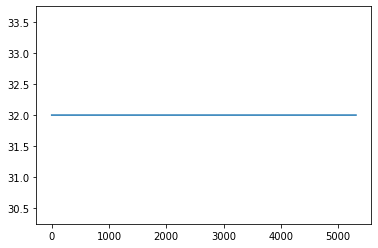

In [12]:
print(mainbuf.shape)
plot(mainbuf[:,0,0,t0,:,0].flat)
assert np.all(mainbuf[:,0,0,t0,:,0] == dmamp)
assert np.all(mainbuf[:,1:,1:,:t0,:,1] == 0)
assert np.all(mainbuf[:,1:,1:,:t0+1,:,1] == 0)
print(mainbuf.sum())

In [13]:
values.run_fdmt = False
values.run_image = True
values.threshold = 3
print(values)
p.run(0, values).wait()

INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=192 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running


Namespace(boxcar_weight='sum', cand_file='candidates.txt', cell=None, device=0, dump_boxcar_hist_buf=None, dump_candidates=None, dump_fdmt_hist_buf=None, dump_mainbufs=None, dump_uvdata=None, fdmt_scale=1.0, fft_scale=10.0, fft_shift1=0, fft_shift2=7, input_scale=1.0, max_ndm=1024, nblocks=1, nbox=8, ncin=32, ndm=2, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', run_fdmt=False, run_image=True, show=False, show_candidate_grid=None, threshold=3, uv='frb_d0_lm0_nt16_nant24.fits', verbose=False, wait=False, xclbin='binary_container_1.xclbin.golden')


INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f8192940960>
INFO:craco.search_pipeline:Call: 0.5134421460097656 Wait:0.0012805229926016182: Total:0.5147226690023672
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81930b8b20>
INFO:craco.search_pipeline:Call: 0.5134421460097656 Wait:0.0029758329910691828: Total:0.5164179790008347
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81930b8ab0>
INFO:craco.search_pipeline:Call: 0.5134421460097656 Wait:0.0045145219773985445: Total:0.5179566679871641
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81930b8c00>
INFO:craco.search_pipeline:Call: 0.5134421460097656 Wait:0.0060142149741295725: Total:0.5194563609838951
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81930b8c38>
INFO:craco.search_pipeline:Call: 0.5134421460097656 Wait:0.00748167597339488

In [14]:
cands = p.get_candidates()
print(f'Got {len(cands)} candidates')
if len(cands) == 0: # are you sure?
    p.candidates.copy_from_device()
    print(p.candidates.nparr)
    
print_candidates(cands, 256, 0)

Got 298 candidates
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		0	0	0
16.4	127	128	0		1	0	0
11.5	129	129	1		1	0	0
3.0	162	129	0		1	0	0
34.9	127	129	0		0	0	0
5.6	138	130	0		0	0	0
5.2	122	130	0		0	0	0
8.0	135	131	0		1	0	0
3.3	105	131	0		0	0	0
5.0	120	131	0		1	0	0
5.2	134	132	1		1	0	0
7.9	124	132	0		0	0	0
8.0	133	133	0		0	0	0
3.5	102	133	0		1	0	0
4.5	123	133	0		0	0	0
6.8	134	134	0		0	0	0
5.2	117	134	0		1	0	0
8.0	131	135	0		1	0	0
3.6	147	135	0		0	0	0
5.6	116	135	0		1	0	0
6.5	136	136	1		1	0	0
3.9	110	136	0		0	0	0
5.2	126	136	1		1	0	0
5.0	131	137	0		0	0	0
3.4	179	137	0		0	0	0
3.3	111	137	1		1	0	0
4.5	118	137	0		1	0	0
5.6	130	138	0		0	0	0
3.4	178	138	1		1	0	0
3.9	108	138	1		1	0	0
4.8	117	138	0		1	0	0
4.5	131	139	0		0	0	0
3.5	181	139	0		1	0	0
3.8	107	139	0		1	0	0
4.6	121	139	0		0	0	0
4.4	122	140	1		1	0	0
3.4	101	141	0		0	0	0
6.1	121	141	1		1	0	0
4.3	100	142	0		0	0	0
6.6	120	142	1		1	0	0
3.7	99	143	1		1	0	0
3.9	119	143	0		0	0	0
3.8	96	144	0		0	0	0
3.1	71	145	0		0	0	0
4.7	95	145	1		1

In [15]:
print(cands)
cands = cands[cands['dm'] == 0] # DM 0 adn 1 are repeated, I think.

[(5342,     0, 0, 0, 0) (1052,   255, 0, 1, 0) ( 734,   257, 1, 1, 0)
 ( 193,   290, 0, 1, 0) (2236,   511, 0, 0, 0) ( 356,   522, 0, 0, 0)
 ( 331,   762, 0, 0, 0) ( 514,   775, 0, 1, 0) ( 213,  1001, 0, 0, 0)
 ( 320,  1016, 0, 1, 0) ( 332,  1030, 1, 1, 0) ( 507,  1276, 0, 0, 0)
 ( 512,  1285, 0, 0, 0) ( 223,  1510, 0, 1, 0) ( 290,  1531, 0, 0, 0)
 ( 437,  1542, 0, 0, 0) ( 336,  1781, 0, 1, 0) ( 509,  1795, 0, 1, 0)
 ( 228,  1811, 0, 0, 0) ( 360,  2036, 0, 1, 0) ( 416,  2056, 1, 1, 0)
 ( 251,  2286, 0, 0, 0) ( 331,  2302, 1, 1, 0) ( 319,  2307, 0, 0, 0)
 ( 218,  2355, 0, 0, 0) ( 213,  2543, 1, 1, 0) ( 288,  2550, 0, 1, 0)
 ( 359,  2562, 0, 0, 0) ( 217,  2610, 1, 1, 0) ( 251,  2796, 1, 1, 0)
 ( 305,  2805, 0, 1, 0) ( 291,  2819, 0, 0, 0) ( 221,  2869, 0, 1, 0)
 ( 241,  3051, 0, 1, 0) ( 293,  3065, 0, 0, 0) ( 279,  3322, 1, 1, 0)
 ( 220,  3557, 0, 0, 0) ( 392,  3577, 1, 1, 0) ( 278,  3812, 0, 0, 0)
 ( 422,  3832, 1, 1, 0) ( 238,  4067, 1, 1, 0) ( 251,  4087, 0, 0, 0)
 ( 243,  4320, 0, 0,

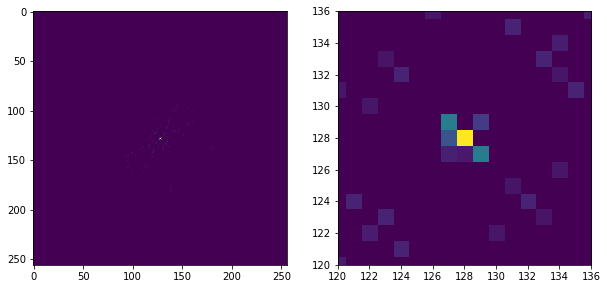

In [16]:
grid = grid_candidates(cands, 'snr')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

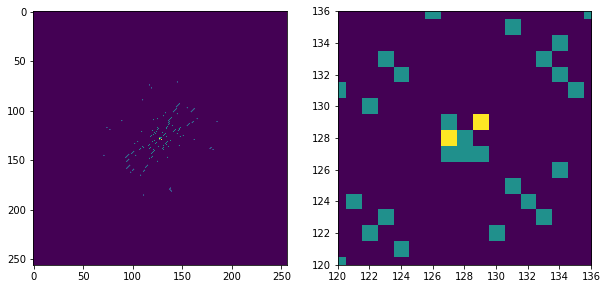

In [17]:
grid = grid_candidates(cands, 'count')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

# Check DM0 for trange makes sense

In [18]:
all_cands = []
for t0 in range(16):
    p.clear_buffers(values)
    # dmamp = 32 gives SNR=14.2
    dmamp = 32
    print('t0', t0)

    # put in a value for a single time and DM
    for b in p.all_mainbufs:
        b.nparr[:] = 0
        b.nparr[:,:,:,t0,:,0] = dmamp
        b.copy_to_device()

    values.run_fdmt = False
    values.run_image = True
    values.threshold = 10
    p.run(0, values).wait()
    cands = p.get_candidates().copy()
    all_cands.append(cands)
    c0 = cands[0]
    print(c0)
    #assert c0['upix'] == 128
    #assert c0['vpix'] == 128
    #assert c0['boxc_width'] == 0
    #assert c0['time'] == t0
    #assert c0['dm'] == 0
    print_candidates(cands, 256, 0)

    

INFO:root:Clearing mainbuf data NBLK=11
INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=192 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f81936201b8>
INFO:craco.search_pipeline:Call: 0.5139593610074371 Wait:0.0015162369818426669: Total:0.5154755979892798
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620298>
INFO:craco.search_pipeline:Call: 0.5139593610074371 Wait:0.0032854639866854995: Total:0.5172448249941226
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81936201f0>
INFO:craco.search_pipeline:Call: 0.5139593610074371 Wait:0.00481096698786132: 

INFO:craco.search_pipeline:Waiting for istart=5 start=<pyxrt.run object at 0x7f81936201b8>
INFO:craco.search_pipeline:Call: 0.5124819530174136 Wait:0.009585788997355849: Total:0.5220677420147695
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f81936202d0>
INFO:craco.search_pipeline:Call: 0.5124819530174136 Wait:0.01172697899164632: Total:0.5242089320090599
INFO:craco.search_pipeline:Waiting for istart=7 start=<pyxrt.run object at 0x7f8193620458>
INFO:craco.search_pipeline:Call: 0.5124819530174136 Wait:0.013376016984693706: Total:0.5258579700021073
INFO:craco.search_pipeline:Waiting for istart=8 start=<pyxrt.run object at 0x7f81936203b0>
INFO:craco.search_pipeline:Call: 0.5124819530174136 Wait:0.014886782999383286: Total:0.5273687360167969
INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f81936204c8>
INFO:craco.search_pipeline:Call: 0.5124819530174136 Wait:0.016239263000898063: Total:0.5287212160183117
INFO:craco.search_pipeline

INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620298>
INFO:craco.search_pipeline:Call: 0.5174046680040192 Wait:0.002932047995273024: Total:0.5203367159992922
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81936203b0>
INFO:craco.search_pipeline:Call: 0.5174046680040192 Wait:0.004513493011472747: Total:0.5219181610154919
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81936201f0>
INFO:craco.search_pipeline:Call: 0.5174046680040192 Wait:0.005888752988539636: Total:0.5232934209925588
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8193620420>
INFO:craco.search_pipeline:Call: 0.5174046680040192 Wait:0.007039023010293022: Total:0.5244436910143122
INFO:craco.search_pipeline:Waiting for istart=5 start=<pyxrt.run object at 0x7f81936203e8>
INFO:craco.search_pipeline:Call: 0.5174046680040192 Wait:0.008130258007440716: Total:0.5255349260114599
INFO:craco.search_pipelin

INFO:craco.search_pipeline:Call: 0.5142371880065184 Wait:0.013220213004387915: Total:0.5274574010109063
INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f8193620228>
INFO:craco.search_pipeline:Call: 0.5142371880065184 Wait:0.014143470005365089: Total:0.5283806580118835
INFO:root:Finished clearing pipeline


t0 0


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f81936201f0>
INFO:craco.search_pipeline:Call: 0.5142131419852376 Wait:0.0012070689990650862: Total:0.5154202109843027
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620378>
INFO:craco.search_pipeline:Call: 0.5142131419852376 Wait:0.002988251013448462: Total:0.5172013929986861
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620260>
INFO:craco.search_pipeline:Call: 0.5142131419852376 Wait:0.0045904970029369: Total:0.5188036389881745
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81936204c8>
INFO:craco

(5342, 0, 0, 0, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		0	0	0
16.4	127	128	0		1	0	0
11.5	129	129	1		1	0	0
34.9	127	129	0		0	0	0
34.9	129	127	0		0	0	0
83.5	128	128	0		0	1	0
16.4	127	128	0		1	1	0
11.5	129	129	1		1	1	0
34.9	127	129	0		0	1	0
34.9	129	127	0		0	1	0


INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f81936201f0>
INFO:craco.search_pipeline:Call: 0.5159549670061097 Wait:0.0013438919850159436: Total:0.5172988589911256
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620378>
INFO:craco.search_pipeline:Call: 0.5159549670061097 Wait:0.0031035970023367554: Total:0.5190585640084464
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620148>
INFO:craco.search_pipeline:Call: 0.5159549670061097 Wait:0.0046565119992010295: Total:0.5206114790053107
INFO:craco.se

INFO:craco.search_pipeline:Call: 0.5154861999908462 Wait:0.009872315014945343: Total:0.5253585150057916
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f81936201f0>
INFO:craco.search_pipeline:Call: 0.5154861999908462 Wait:0.011427576013375074: Total:0.5269137760042213
INFO:craco.search_pipeline:Waiting for istart=7 start=<pyxrt.run object at 0x7f8193620570>
INFO:craco.search_pipeline:Call: 0.5154861999908462 Wait:0.012763892009388655: Total:0.5282500920002349
INFO:craco.search_pipeline:Waiting for istart=8 start=<pyxrt.run object at 0x7f8193620148>
INFO:craco.search_pipeline:Call: 0.5154861999908462 Wait:0.013672441011294723: Total:0.5291586410021409
INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f81936204c8>
INFO:craco.search_pipeline:Call: 0.5154861999908462 Wait:0.014575781999155879: Total:0.5300619819900021
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=4 nuv=5272 nparall

INFO:craco.search_pipeline:Call: 0.5169598600186873 Wait:0.003725877992110327: Total:0.5206857380107976
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81936203b0>
INFO:craco.search_pipeline:Call: 0.5169598600186873 Wait:0.005538665980566293: Total:0.5224985259992536
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8193620378>
INFO:craco.search_pipeline:Call: 0.5169598600186873 Wait:0.0069069479941390455: Total:0.5238668080128264
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8193620458>
INFO:craco.search_pipeline:Call: 0.5169598600186873 Wait:0.008231535990489647: Total:0.525191396009177
INFO:craco.search_pipeline:Waiting for istart=5 start=<pyxrt.run object at 0x7f81936201f0>
INFO:craco.search_pipeline:Call: 0.5169598600186873 Wait:0.011607897002249956: Total:0.5285677570209373
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f8193620260>
INFO:craco.search_pipelin

INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f8193620538>
INFO:craco.search_pipeline:Call: 0.512865683005657 Wait:0.015112894994672388: Total:0.5279785780003294
INFO:root:Finished clearing pipeline


t0 1


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f81935a7688>
INFO:craco.search_pipeline:Call: 0.5138951599947177 Wait:0.0011307639942970127: Total:0.5150259239890147
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620458>
INFO:craco.search_pipeline:Call: 0.5138951599947177 Wait:0.0032610910129733384: Total:0.517156251007691
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620500>
INFO:craco.search_pipeline:Call: 0.5138951599947177 Wait:0.005139929009601474: Total:0.5190350890043192
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8193620490>
INFO:cra

(5342, 0, 0, 1, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		1	0	0
16.4	128	129	0		0	0	0
34.9	127	129	0		1	0	0
34.9	129	127	0		1	0	0
11.5	127	127	1		1	0	0
28.7	128	128	7		8	0	0
12.0	127	129	7		8	0	0
12.0	129	127	7		8	0	0
83.5	128	128	0		1	1	0
16.4	128	129	0		0	1	0
34.9	127	129	0		1	1	0
34.9	129	127	0		1	1	0
11.5	127	127	1		1	1	0
28.7	128	128	7		8	1	0
12.0	127	129	7		8	1	0
12.0	129	127	7		8	1	0


INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f8193620500>
INFO:craco.search_pipeline:Call: 0.5136675110261422 Wait:0.0013075709866825491: Total:0.5149750820128247
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620490>
INFO:craco.search_pipeline:Call: 0.5136675110261422 Wait:0.0032572369964327663: Total:0.5169247480225749
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620148>
INFO:craco.search_pipeline:Call: 0.5136675110261422 Wait:0.004889565985649824: Total:0.518557077011792
INFO:craco.sear

INFO:craco.search_pipeline:Call: 0.5155567680194508 Wait:0.009720589005155489: Total:0.5252773570246063
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f8193620420>
INFO:craco.search_pipeline:Call: 0.5155567680194508 Wait:0.011254511977313086: Total:0.5268112799967639
INFO:craco.search_pipeline:Waiting for istart=7 start=<pyxrt.run object at 0x7f8193620148>
INFO:craco.search_pipeline:Call: 0.5155567680194508 Wait:0.012432535004336387: Total:0.5279893030237872
INFO:craco.search_pipeline:Waiting for istart=8 start=<pyxrt.run object at 0x7f8193620298>
INFO:craco.search_pipeline:Call: 0.5155567680194508 Wait:0.0134096399997361: Total:0.5289664080191869
INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f81936201b8>
INFO:craco.search_pipeline:Call: 0.5155567680194508 Wait:0.014408350980374962: Total:0.5299651189998258
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=4 nuv=5272 nparallel

INFO:craco.search_pipeline:Call: 0.5147500899911392 Wait:0.0035785350191872567: Total:0.5183286250103265
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620228>
INFO:craco.search_pipeline:Call: 0.5147500899911392 Wait:0.005526619002921507: Total:0.5202767089940608
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81936203e8>
INFO:craco.search_pipeline:Call: 0.5147500899911392 Wait:0.007433328020852059: Total:0.5221834180119913
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8193620490>
INFO:craco.search_pipeline:Call: 0.5147500899911392 Wait:0.009364198020193726: Total:0.524114288011333
INFO:craco.search_pipeline:Waiting for istart=5 start=<pyxrt.run object at 0x7f81936204c8>
INFO:craco.search_pipeline:Call: 0.5147500899911392 Wait:0.011326105013722554: Total:0.5260761950048618
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f81936201f0>
INFO:craco.search_pipelin

INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f8193620420>
INFO:craco.search_pipeline:Call: 0.5146177459973842 Wait:0.014447152992943302: Total:0.5290648989903275
INFO:root:Finished clearing pipeline


t0 2


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f81935a7688>
INFO:craco.search_pipeline:Call: 0.5126635950000491 Wait:0.0013372759858611971: Total:0.5140008709859103
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620500>
INFO:craco.search_pipeline:Call: 0.5126635950000491 Wait:0.003191349998814985: Total:0.5158549449988641
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81936204c8>
INFO:craco.search_pipeline:Call: 0.5126635950000491 Wait:0.004849605000345036: Total:0.5175132000003941
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8193620308>
INFO:cra

(5342, 0, 0, 2, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		2	0	0
16.4	127	128	0		3	0	0
11.5	129	129	1		3	0	0
34.9	127	129	0		2	0	0
34.9	129	127	0		2	0	0
31.3	128	128	6		8	0	0
13.1	127	129	6		8	0	0
13.1	129	127	6		8	0	0
83.5	128	128	0		2	1	0
16.4	127	128	0		3	1	0
11.5	129	129	1		3	1	0
34.9	127	129	0		2	1	0
34.9	129	127	0		2	1	0
31.3	128	128	6		8	1	0
13.1	127	129	6		8	1	0
13.1	129	127	6		8	1	0


INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f81936204c8>
INFO:craco.search_pipeline:Call: 0.5134683359938208 Wait:0.0014235569979064167: Total:0.5148918929917272
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620308>
INFO:craco.search_pipeline:Call: 0.5134683359938208 Wait:0.0032341890037059784: Total:0.5167025249975268
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620538>
INFO:craco.search_pipeline:Call: 0.5134683359938208 Wait:0.005079588008811697: Total:0.5185479240026325
INFO:craco.sea

INFO:craco.search_pipeline:Call: 0.5147132640122436 Wait:0.011389988998416811: Total:0.5261032530106604
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f8193620458>
INFO:craco.search_pipeline:Call: 0.5147132640122436 Wait:0.012422050989698619: Total:0.5271353150019422
INFO:craco.search_pipeline:Waiting for istart=7 start=<pyxrt.run object at 0x7f81936203e8>
INFO:craco.search_pipeline:Call: 0.5147132640122436 Wait:0.01349720498546958: Total:0.5282104689977132
INFO:craco.search_pipeline:Waiting for istart=8 start=<pyxrt.run object at 0x7f8193620260>
INFO:craco.search_pipeline:Call: 0.5147132640122436 Wait:0.014620250003645197: Total:0.5293335140158888
INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f81936203b0>
INFO:craco.search_pipeline:Call: 0.5147132640122436 Wait:0.015755026979604736: Total:0.5304682909918483
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=4 nuv=5272 nparalle

INFO:craco.search_pipeline:Call: 0.514118482999038 Wait:0.0029897479980718344: Total:0.5171082309971098
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81936203b0>
INFO:craco.search_pipeline:Call: 0.514118482999038 Wait:0.004594419006025419: Total:0.5187129020050634
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81936201f0>
INFO:craco.search_pipeline:Call: 0.514118482999038 Wait:0.006141752994153649: Total:0.5202602359931916
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81936202d0>
INFO:craco.search_pipeline:Call: 0.514118482999038 Wait:0.007607792998896912: Total:0.5217262759979349
INFO:craco.search_pipeline:Waiting for istart=5 start=<pyxrt.run object at 0x7f81936204c8>
INFO:craco.search_pipeline:Call: 0.514118482999038 Wait:0.00864498398732394: Total:0.5227634669863619
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f8193620538>
INFO:craco.search_pipeline:Cal

INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f8193620260>
INFO:craco.search_pipeline:Call: 0.5147836289834231 Wait:0.014050550991669297: Total:0.5288341799750924
INFO:root:Finished clearing pipeline


t0 3


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f81936202d0>
INFO:craco.search_pipeline:Call: 0.5133472459856421 Wait:0.0015883790038060397: Total:0.5149356249894481
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620298>
INFO:craco.search_pipeline:Call: 0.5133472459856421 Wait:0.0032261449960060418: Total:0.5165733909816481
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620500>
INFO:craco.search_pipeline:Call: 0.5133472459856421 Wait:0.004721173987491056: Total:0.5180684199731331
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8193620378>
INFO:cr

(5342, 0, 0, 3, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		3	0	0
16.4	128	129	0		2	0	0
34.9	127	129	0		3	0	0
34.9	129	127	0		3	0	0
11.5	127	127	1		3	0	0
33.9	128	128	5		8	0	0
14.2	127	129	5		8	0	0
14.2	129	127	5		8	0	0
83.5	128	128	0		3	1	0
16.4	128	129	0		2	1	0
34.9	127	129	0		3	1	0
34.9	129	127	0		3	1	0
11.5	127	127	1		3	1	0
33.9	128	128	5		8	1	0
14.2	127	129	5		8	1	0
14.2	129	127	5		8	1	0


INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f8193620490>
INFO:craco.search_pipeline:Call: 0.5090350749960635 Wait:0.0012300499947741628: Total:0.5102651249908376
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81936202d0>
INFO:craco.search_pipeline:Call: 0.5090350749960635 Wait:0.0029815570160280913: Total:0.5120166320120916
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620378>
INFO:craco.search_pipeline:Call: 0.5090350749960635 Wait:0.004467495018616319: Total:0.5135025700146798
INFO:craco.sea

INFO:craco.search_pipeline:Call: 0.5150421550206374 Wait:0.009790126990992576: Total:0.52483228201163
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f8193620458>
INFO:craco.search_pipeline:Call: 0.5150421550206374 Wait:0.010959563980577514: Total:0.526001719001215
INFO:craco.search_pipeline:Waiting for istart=7 start=<pyxrt.run object at 0x7f8193620308>
INFO:craco.search_pipeline:Call: 0.5150421550206374 Wait:0.012002645002212375: Total:0.5270448000228498
INFO:craco.search_pipeline:Waiting for istart=8 start=<pyxrt.run object at 0x7f81936203e8>
INFO:craco.search_pipeline:Call: 0.5150421550206374 Wait:0.013060869998298585: Total:0.528103025018936
INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f8193620538>
INFO:craco.search_pipeline:Call: 0.5150421550206374 Wait:0.014128101000096649: Total:0.5291702560207341
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=4 nuv=5272 nparallel_u

INFO:craco.search_pipeline:Call: 0.5143213240080513 Wait:0.0031130919815041125: Total:0.5174344159895554
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620378>
INFO:craco.search_pipeline:Call: 0.5143213240080513 Wait:0.004765947989653796: Total:0.5190872719977051
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8193620260>
INFO:craco.search_pipeline:Call: 0.5143213240080513 Wait:0.00638208698364906: Total:0.5207034109917004
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8193620500>
INFO:craco.search_pipeline:Call: 0.5143213240080513 Wait:0.007972238992806524: Total:0.5222935630008578
INFO:craco.search_pipeline:Waiting for istart=5 start=<pyxrt.run object at 0x7f8193620340>
INFO:craco.search_pipeline:Call: 0.5143213240080513 Wait:0.009565644984832034: Total:0.5238869689928833
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f81936201b8>
INFO:craco.search_pipelin

INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f8193620420>
INFO:craco.search_pipeline:Call: 0.5137059300031979 Wait:0.014176950993714854: Total:0.5278828809969127
INFO:root:Finished clearing pipeline


t0 4


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f8193620260>
INFO:craco.search_pipeline:Call: 0.5116706039989367 Wait:0.0014373979938682169: Total:0.5131080019928049
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81936201b8>
INFO:craco.search_pipeline:Call: 0.5116706039989367 Wait:0.0031570380087941885: Total:0.5148276420077309
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620298>
INFO:craco.search_pipeline:Call: 0.5116706039989367 Wait:0.004711604007752612: Total:0.5163822080066893
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8193620458>
INFO:cr

(5342, 0, 0, 4, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		4	0	0
16.4	127	128	0		5	0	0
11.5	129	129	1		5	0	0
34.9	127	129	0		4	0	0
34.9	129	127	0		4	0	0
36.5	128	128	4		8	0	0
15.2	127	129	4		8	0	0
15.3	129	127	4		8	0	0
83.5	128	128	0		4	1	0
16.4	127	128	0		5	1	0
11.5	129	129	1		5	1	0
34.9	127	129	0		4	1	0
34.9	129	127	0		4	1	0
36.5	128	128	4		8	1	0
15.2	127	129	4		8	1	0
15.3	129	127	4		8	1	0


INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f81936201b8>
INFO:craco.search_pipeline:Call: 0.5136809250107035 Wait:0.001099319983040914: Total:0.5147802449937444
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620298>
INFO:craco.search_pipeline:Call: 0.5136809250107035 Wait:0.0026930849999189377: Total:0.5163740100106224
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620458>
INFO:craco.search_pipeline:Call: 0.5136809250107035 Wait:0.004197122994810343: Total:0.5178780480055138
INFO:craco.sear

INFO:craco.search_pipeline:Call: 0.5149987929908093 Wait:0.009372113010613248: Total:0.5243709060014226
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f8193620570>
INFO:craco.search_pipeline:Call: 0.5149987929908093 Wait:0.010578496992820874: Total:0.5255772899836302
INFO:craco.search_pipeline:Waiting for istart=7 start=<pyxrt.run object at 0x7f81936201f0>
INFO:craco.search_pipeline:Call: 0.5149987929908093 Wait:0.011606212996412069: Total:0.5266050059872214
INFO:craco.search_pipeline:Waiting for istart=8 start=<pyxrt.run object at 0x7f8193620228>
INFO:craco.search_pipeline:Call: 0.5149987929908093 Wait:0.012634001992410049: Total:0.5276327949832194
INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f81936203b0>
INFO:craco.search_pipeline:Call: 0.5149987929908093 Wait:0.01383909399737604: Total:0.5288378869881853
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=4 nuv=5272 nparalle

INFO:craco.search_pipeline:Call: 0.5145486690162215 Wait:0.0035028349957428873: Total:0.5180515040119644
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620308>
INFO:craco.search_pipeline:Call: 0.5145486690162215 Wait:0.00515212697791867: Total:0.5197007959941402
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8193620458>
INFO:craco.search_pipeline:Call: 0.5145486690162215 Wait:0.006753918976755813: Total:0.5213025879929774
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8193620420>
INFO:craco.search_pipeline:Call: 0.5145486690162215 Wait:0.008260294998763129: Total:0.5228089640149847
INFO:craco.search_pipeline:Waiting for istart=5 start=<pyxrt.run object at 0x7f8193620570>
INFO:craco.search_pipeline:Call: 0.5145486690162215 Wait:0.009797327977139503: Total:0.524345996993361
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f8193620260>
INFO:craco.search_pipeline

INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f8193620538>
INFO:craco.search_pipeline:Call: 0.5151617790106684 Wait:0.014371056982781738: Total:0.5295328359934501
INFO:root:Finished clearing pipeline


t0 5


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f81935a7688>
INFO:craco.search_pipeline:Call: 0.5128535289841238 Wait:0.001323142001638189: Total:0.514176670985762
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81936204c8>
INFO:craco.search_pipeline:Call: 0.5128535289841238 Wait:0.0029599330155178905: Total:0.5158134619996417
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620148>
INFO:craco.search_pipeline:Call: 0.5128535289841238 Wait:0.004478404996916652: Total:0.5173319339810405
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8193620490>
INFO:crac

(5342, 0, 0, 5, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		5	0	0
16.4	128	129	0		4	0	0
34.9	127	129	0		5	0	0
34.9	129	127	0		5	0	0
11.5	127	127	1		5	0	0
41.7	128	128	3		8	0	0
17.5	127	129	3		8	0	0
17.5	129	127	3		8	0	0
83.5	128	128	0		5	1	0
16.4	128	129	0		4	1	0
34.9	127	129	0		5	1	0
34.9	129	127	0		5	1	0
11.5	127	127	1		5	1	0
41.7	128	128	3		8	1	0
17.5	127	129	3		8	1	0
17.5	129	127	3		8	1	0


INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f81936204c8>
INFO:craco.search_pipeline:Call: 0.5107413140067365 Wait:0.0012791119806934148: Total:0.5120204259874299
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620340>
INFO:craco.search_pipeline:Call: 0.5107413140067365 Wait:0.0025935969897545874: Total:0.5133349109964911
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620228>
INFO:craco.search_pipeline:Call: 0.5107413140067365 Wait:0.003622720978455618: Total:0.5143640349851921
INFO:craco.sea

INFO:craco.search_pipeline:Call: 0.5161254690028727 Wait:0.010187886975472793: Total:0.5263133559783455
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f8193620458>
INFO:craco.search_pipeline:Call: 0.5161254690028727 Wait:0.011644227983197197: Total:0.5277696969860699
INFO:craco.search_pipeline:Waiting for istart=7 start=<pyxrt.run object at 0x7f8193620148>
INFO:craco.search_pipeline:Call: 0.5161254690028727 Wait:0.012729826994473115: Total:0.5288552959973458
INFO:craco.search_pipeline:Waiting for istart=8 start=<pyxrt.run object at 0x7f8193620298>
INFO:craco.search_pipeline:Call: 0.5161254690028727 Wait:0.013734296982875094: Total:0.5298597659857478
INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f8193620340>
INFO:craco.search_pipeline:Call: 0.5161254690028727 Wait:0.014819860982242972: Total:0.5309453299851157
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=4 nuv=5272 nparall

INFO:craco.search_pipeline:Call: 0.5152796469919849 Wait:0.003183280990924686: Total:0.5184629279829096
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620340>
INFO:craco.search_pipeline:Call: 0.5152796469919849 Wait:0.005209213006310165: Total:0.5204888599982951
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8193620420>
INFO:craco.search_pipeline:Call: 0.5152796469919849 Wait:0.007131669990485534: Total:0.5224113169824705
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8193620500>
INFO:craco.search_pipeline:Call: 0.5152796469919849 Wait:0.00908290600636974: Total:0.5243625529983547
INFO:craco.search_pipeline:Waiting for istart=5 start=<pyxrt.run object at 0x7f8193620538>
INFO:craco.search_pipeline:Call: 0.5152796469919849 Wait:0.010971134004648775: Total:0.5262507809966337
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f8193620490>
INFO:craco.search_pipeline

INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f8193620420>
INFO:craco.search_pipeline:Call: 0.515672554000048 Wait:0.016202372004045174: Total:0.5318749260040931
INFO:root:Finished clearing pipeline


t0 6


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f81935a7688>
INFO:craco.search_pipeline:Call: 0.5132862710161135 Wait:0.0011267850059084594: Total:0.5144130560220219
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620458>
INFO:craco.search_pipeline:Call: 0.5132862710161135 Wait:0.0034881969913840294: Total:0.5167744680074975
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620298>
INFO:craco.search_pipeline:Call: 0.5132862710161135 Wait:0.005978600995149463: Total:0.5192648720112629
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8193620570>
INFO:cr

(5342, 0, 0, 6, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		6	0	0
16.4	127	128	0		7	0	0
11.5	129	129	1		7	0	0
34.9	127	129	0		6	0	0
34.9	129	127	0		6	0	0
46.9	128	128	2		8	0	0
11.5	127	128	1		8	0	0
19.6	127	129	2		8	0	0
19.7	129	127	2		8	0	0
83.5	128	128	0		6	1	0
16.4	127	128	0		7	1	0
11.5	129	129	1		7	1	0
34.9	127	129	0		6	1	0
34.9	129	127	0		6	1	0
46.9	128	128	2		8	1	0
11.5	127	128	1		8	1	0
19.6	127	129	2		8	1	0
19.7	129	127	2		8	1	0


INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f8193620298>
INFO:craco.search_pipeline:Call: 0.5155305810039863 Wait:0.0011138260015286505: Total:0.516644407005515
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620570>
INFO:craco.search_pipeline:Call: 0.5155305810039863 Wait:0.0035604879958555102: Total:0.5190910689998418
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81936204c8>
INFO:craco.search_pipeline:Call: 0.5155305810039863 Wait:0.007770503987558186: Total:0.5233010849915445
INFO:craco.sear

INFO:craco.search_pipeline:Call: 0.5195313139993232 Wait:0.010095831996295601: Total:0.5296271459956188
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f8193620420>
INFO:craco.search_pipeline:Call: 0.5195313139993232 Wait:0.011795083992183208: Total:0.5313263979915064
INFO:craco.search_pipeline:Waiting for istart=7 start=<pyxrt.run object at 0x7f8193620308>
INFO:craco.search_pipeline:Call: 0.5195313139993232 Wait:0.013034948002314195: Total:0.5325662620016374
INFO:craco.search_pipeline:Waiting for istart=8 start=<pyxrt.run object at 0x7f81936202d0>
INFO:craco.search_pipeline:Call: 0.5195313139993232 Wait:0.013902812002925202: Total:0.5334341260022484
INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f8193620570>
INFO:craco.search_pipeline:Call: 0.5195313139993232 Wait:0.01474385999608785: Total:0.534275173995411
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=4 nuv=5272 nparallel

INFO:craco.search_pipeline:Call: 0.5150449560023844 Wait:0.002724430989474058: Total:0.5177693869918585
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620308>
INFO:craco.search_pipeline:Call: 0.5150449560023844 Wait:0.004276450985344127: Total:0.5193214069877286
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8193620570>
INFO:craco.search_pipeline:Call: 0.5150449560023844 Wait:0.005815468990476802: Total:0.5208604249928612
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8193620260>
INFO:craco.search_pipeline:Call: 0.5150449560023844 Wait:0.007335289003094658: Total:0.5223802450054791
INFO:craco.search_pipeline:Waiting for istart=5 start=<pyxrt.run object at 0x7f81936203e8>
INFO:craco.search_pipeline:Call: 0.5150449560023844 Wait:0.008848609984852374: Total:0.5238935659872368
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f8193620458>
INFO:craco.search_pipelin

INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f81936201b8>
INFO:craco.search_pipeline:Call: 0.5196076889988035 Wait:0.015841700980672613: Total:0.5354493899794761
INFO:root:Finished clearing pipeline


t0 7


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f81936201f0>
INFO:craco.search_pipeline:Call: 0.512476724019507 Wait:0.0012692899908870459: Total:0.513746014010394
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620490>
INFO:craco.search_pipeline:Call: 0.512476724019507 Wait:0.0030321469821501523: Total:0.5155088710016571
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620420>
INFO:craco.search_pipeline:Call: 0.512476724019507 Wait:0.004667985980631784: Total:0.5171447100001387
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81936204c8>
INFO:craco.

(5342, 0, 0, 7, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		7	0	0
16.4	128	129	0		6	0	0
34.9	127	129	0		7	0	0
34.9	129	127	0		7	0	0
11.5	127	127	1		7	0	0
58.7	128	128	1		8	0	0
24.6	127	129	1		8	0	0
24.6	129	127	1		8	0	0
83.5	128	128	0		7	1	0
16.4	128	129	0		6	1	0
34.9	127	129	0		7	1	0
34.9	129	127	0		7	1	0
11.5	127	127	1		7	1	0
58.7	128	128	1		8	1	0
24.6	127	129	1		8	1	0
24.6	129	127	1		8	1	0


INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f8193620420>
INFO:craco.search_pipeline:Call: 0.512936451996211 Wait:0.001402469992171973: Total:0.5143389219883829
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81936204c8>
INFO:craco.search_pipeline:Call: 0.512936451996211 Wait:0.0032470939913764596: Total:0.5161835459875874
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620500>
INFO:craco.search_pipeline:Call: 0.512936451996211 Wait:0.004766034981003031: Total:0.517702486977214
INFO:craco.search_p

INFO:craco.search_pipeline:Call: 0.5160138480132446 Wait:0.009490539989201352: Total:0.5255043880024459
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f81936204c8>
INFO:craco.search_pipeline:Call: 0.5160138480132446 Wait:0.010967598005663604: Total:0.5269814460189082
INFO:craco.search_pipeline:Waiting for istart=7 start=<pyxrt.run object at 0x7f8193620340>
INFO:craco.search_pipeline:Call: 0.5160138480132446 Wait:0.012212923989864066: Total:0.5282267720031086
INFO:craco.search_pipeline:Waiting for istart=8 start=<pyxrt.run object at 0x7f8193620308>
INFO:craco.search_pipeline:Call: 0.5160138480132446 Wait:0.013225598988356069: Total:0.5292394470016006
INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f8193620260>
INFO:craco.search_pipeline:Call: 0.5160138480132446 Wait:0.01417661999585107: Total:0.5301904680090956
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=4 nuv=5272 nparalle

INFO:craco.search_pipeline:Call: 0.515190674981568 Wait:0.002960256999358535: Total:0.5181509319809265
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620340>
INFO:craco.search_pipeline:Call: 0.515190674981568 Wait:0.004409273009514436: Total:0.5195999479910824
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8193620260>
INFO:craco.search_pipeline:Call: 0.515190674981568 Wait:0.005743542016716674: Total:0.5209342169982847
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81936203e8>
INFO:craco.search_pipeline:Call: 0.515190674981568 Wait:0.007082078023813665: Total:0.5222727530053817
INFO:craco.search_pipeline:Waiting for istart=5 start=<pyxrt.run object at 0x7f8193620378>
INFO:craco.search_pipeline:Call: 0.515190674981568 Wait:0.009014273004140705: Total:0.5242049479857087
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f8193620148>
INFO:craco.search_pipeline:Cal

INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f81936203b0>
INFO:craco.search_pipeline:Call: 0.5140920040139463 Wait:0.013199754990637302: Total:0.5272917590045836
INFO:root:Finished clearing pipeline


t0 8


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f8193620260>
INFO:craco.search_pipeline:Call: 0.5137948899937328 Wait:0.0010011809936258942: Total:0.5147960709873587
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620340>
INFO:craco.search_pipeline:Call: 0.5137948899937328 Wait:0.002729733008891344: Total:0.5165246230026241
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81936204c8>
INFO:craco.search_pipeline:Call: 0.5137948899937328 Wait:0.004356193996500224: Total:0.518151083990233
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81936202d0>
INFO:crac

(5342, 0, 0, 8, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		8	0	0
16.4	127	128	0		9	0	0
11.5	129	129	1		9	0	0
34.9	127	129	0		8	0	0
34.9	129	127	0		8	0	0
83.5	128	128	0		8	1	0
16.4	127	128	0		9	1	0
11.5	129	129	1		9	1	0
34.9	127	129	0		8	1	0
34.9	129	127	0		8	1	0


INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f8193620308>
INFO:craco.search_pipeline:Call: 0.5139506550040096 Wait:0.0012634150043595582: Total:0.5152140700083692
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620260>
INFO:craco.search_pipeline:Call: 0.5139506550040096 Wait:0.006849317986052483: Total:0.5207999729900621
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81936202d0>
INFO:craco.search_pipeline:Call: 0.5139506550040096 Wait:0.008464143000310287: Total:0.5224147980043199
INFO:craco.sear

INFO:craco.search_pipeline:Call: 0.5151586660067551 Wait:0.0082356869825162: Total:0.5233943529892713
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f8193620378>
INFO:craco.search_pipeline:Call: 0.5151586660067551 Wait:0.009558192978147417: Total:0.5247168589849025
INFO:craco.search_pipeline:Waiting for istart=7 start=<pyxrt.run object at 0x7f8193620148>
INFO:craco.search_pipeline:Call: 0.5151586660067551 Wait:0.010862796974834055: Total:0.5260214629815891
INFO:craco.search_pipeline:Waiting for istart=8 start=<pyxrt.run object at 0x7f81936201b8>
INFO:craco.search_pipeline:Call: 0.5151586660067551 Wait:0.01213575797737576: Total:0.5272944239841308
INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f8193620228>
INFO:craco.search_pipeline:Call: 0.5151586660067551 Wait:0.013287679001223296: Total:0.5284463450079784
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=4 nuv=5272 nparallel_

INFO:craco.search_pipeline:Call: 0.5198020100069698 Wait:0.0026205900066997856: Total:0.5224226000136696
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81936202d0>
INFO:craco.search_pipeline:Call: 0.5198020100069698 Wait:0.004048681003041565: Total:0.5238506910100114
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81936203b0>
INFO:craco.search_pipeline:Call: 0.5198020100069698 Wait:0.005446035007480532: Total:0.5252480450144503
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8193620260>
INFO:craco.search_pipeline:Call: 0.5198020100069698 Wait:0.007096518995240331: Total:0.5268985290022101
INFO:craco.search_pipeline:Waiting for istart=5 start=<pyxrt.run object at 0x7f8193620340>
INFO:craco.search_pipeline:Call: 0.5198020100069698 Wait:0.011881181999342516: Total:0.5316831920063123
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f8193620538>
INFO:craco.search_pipeli

INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f81936201f0>
INFO:craco.search_pipeline:Call: 0.5197781899769325 Wait:0.012847286008764058: Total:0.5326254759856965
INFO:root:Finished clearing pipeline


t0 9


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f8193620148>
INFO:craco.search_pipeline:Call: 0.5129679539822973 Wait:0.0010568160214461386: Total:0.5140247700037435
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620378>
INFO:craco.search_pipeline:Call: 0.5129679539822973 Wait:0.0027302319940645248: Total:0.5156981859763619
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620570>
INFO:craco.search_pipeline:Call: 0.5129679539822973 Wait:0.004215470020426437: Total:0.5171834240027238
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81936204c8>
INFO:cr

(5342, 0, 0, 9, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		9	0	0
16.4	128	129	0		8	0	0
34.9	127	129	0		9	0	0
34.9	129	127	0		9	0	0
11.5	127	127	1		9	0	0
28.7	128	128	7		16	0	0
12.0	127	129	7		16	0	0
12.0	129	127	7		16	0	0
83.5	128	128	0		9	1	0
16.4	128	129	0		8	1	0
34.9	127	129	0		9	1	0
34.9	129	127	0		9	1	0
11.5	127	127	1		9	1	0
28.7	128	128	7		16	1	0
12.0	127	129	7		16	1	0
12.0	129	127	7		16	1	0


INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f8193620570>
INFO:craco.search_pipeline:Call: 0.5158238869917113 Wait:0.0015264789981301874: Total:0.5173503659898415
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81936204c8>
INFO:craco.search_pipeline:Call: 0.5158238869917113 Wait:0.003863098012516275: Total:0.5196869850042276
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620458>
INFO:craco.search_pipeline:Call: 0.5158238869917113 Wait:0.0063488230225630105: Total:0.5221727100142743
INFO:craco.sea

INFO:craco.search_pipeline:Call: 0.5148069600109011 Wait:0.009362918994156644: Total:0.5241698790050577
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f8193620458>
INFO:craco.search_pipeline:Call: 0.5148069600109011 Wait:0.010532897984376177: Total:0.5253398579952773
INFO:craco.search_pipeline:Waiting for istart=7 start=<pyxrt.run object at 0x7f8193620340>
INFO:craco.search_pipeline:Call: 0.5148069600109011 Wait:0.011708083999110386: Total:0.5265150440100115
INFO:craco.search_pipeline:Waiting for istart=8 start=<pyxrt.run object at 0x7f81936201b8>
INFO:craco.search_pipeline:Call: 0.5148069600109011 Wait:0.012857802008511499: Total:0.5276647620194126
INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f8193620570>
INFO:craco.search_pipeline:Call: 0.5148069600109011 Wait:0.014239481010008603: Total:0.5290464410209097
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=4 nuv=5272 nparall

INFO:craco.search_pipeline:Call: 0.5205176360032056 Wait:0.003254087991081178: Total:0.5237717239942867
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81936201b8>
INFO:craco.search_pipeline:Call: 0.5205176360032056 Wait:0.004648647009162232: Total:0.5251662830123678
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8193620298>
INFO:craco.search_pipeline:Call: 0.5205176360032056 Wait:0.006629068986512721: Total:0.5271467049897183
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81936202d0>
INFO:craco.search_pipeline:Call: 0.5205176360032056 Wait:0.008241014991654083: Total:0.5287586509948596
INFO:craco.search_pipeline:Waiting for istart=5 start=<pyxrt.run object at 0x7f8193620500>
INFO:craco.search_pipeline:Call: 0.5205176360032056 Wait:0.009750400990014896: Total:0.5302680369932204
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f81936204c8>
INFO:craco.search_pipelin

INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f8193620378>
INFO:craco.search_pipeline:Call: 0.5151220330153592 Wait:0.013602215010905638: Total:0.5287242480262648
INFO:root:Finished clearing pipeline


t0 10


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f81936202d0>
INFO:craco.search_pipeline:Call: 0.5141065120114945 Wait:0.0011754140141420066: Total:0.5152819260256365
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620458>
INFO:craco.search_pipeline:Call: 0.5141065120114945 Wait:0.002573541016317904: Total:0.5166800530278124
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81936201f0>
INFO:craco.search_pipeline:Call: 0.5141065120114945 Wait:0.003875871014315635: Total:0.5179823830258101
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8193620420>
INFO:cra

(5342, 0, 0, 10, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		10	0	0
16.4	127	128	0		11	0	0
11.5	129	129	1		11	0	0
34.9	127	129	0		10	0	0
34.9	129	127	0		10	0	0
31.3	128	128	6		16	0	0
13.1	127	129	6		16	0	0
13.1	129	127	6		16	0	0
83.5	128	128	0		10	1	0
16.4	127	128	0		11	1	0
11.5	129	129	1		11	1	0
34.9	127	129	0		10	1	0
34.9	129	127	0		10	1	0
31.3	128	128	6		16	1	0
13.1	127	129	6		16	1	0
13.1	129	127	6		16	1	0


INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f8193620458>
INFO:craco.search_pipeline:Call: 0.5132383980089799 Wait:0.0014334839943330735: Total:0.5146718820033129
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81936201f0>
INFO:craco.search_pipeline:Call: 0.5132383980089799 Wait:0.0033192900009453297: Total:0.5165576880099252
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620420>
INFO:craco.search_pipeline:Call: 0.5132383980089799 Wait:0.004897638980764896: Total:0.5181360369897448
INFO:craco.sea

INFO:craco.search_pipeline:Call: 0.516090783989057 Wait:0.008818064001388848: Total:0.5249088479904458
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f8193620570>
INFO:craco.search_pipeline:Call: 0.516090783989057 Wait:0.009776051010703668: Total:0.5258668349997606
INFO:craco.search_pipeline:Waiting for istart=7 start=<pyxrt.run object at 0x7f8193620228>
INFO:craco.search_pipeline:Call: 0.516090783989057 Wait:0.010737476986832917: Total:0.5268282609758899
INFO:craco.search_pipeline:Waiting for istart=8 start=<pyxrt.run object at 0x7f81936203e8>
INFO:craco.search_pipeline:Call: 0.516090783989057 Wait:0.011696664994815364: Total:0.5277874489838723
INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f81936201f0>
INFO:craco.search_pipeline:Call: 0.516090783989057 Wait:0.012677218997851014: Total:0.528768002986908
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=4 nuv=5272 nparallel_uv=

INFO:craco.search_pipeline:Call: 0.5154902230133303 Wait:0.002932055009296164: Total:0.5184222780226264
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81936204c8>
INFO:craco.search_pipeline:Call: 0.5154902230133303 Wait:0.004311780008720234: Total:0.5198020030220505
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8193620500>
INFO:craco.search_pipeline:Call: 0.5154902230133303 Wait:0.005647079990012571: Total:0.5211373030033428
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8193620340>
INFO:craco.search_pipeline:Call: 0.5154902230133303 Wait:0.0071024789940565825: Total:0.5225927020073868
INFO:craco.search_pipeline:Waiting for istart=5 start=<pyxrt.run object at 0x7f8193620570>
INFO:craco.search_pipeline:Call: 0.5154902230133303 Wait:0.008465472987154499: Total:0.5239556960004847
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f81936203b0>
INFO:craco.search_pipeli

INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f81936204c8>
INFO:craco.search_pipeline:Call: 0.5168377890076954 Wait:0.013362440979108214: Total:0.5302002299868036
INFO:root:Finished clearing pipeline


t0 11


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f81936203b0>
INFO:craco.search_pipeline:Call: 0.5128715669852681 Wait:0.0016467270033899695: Total:0.5145182939886581
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620340>
INFO:craco.search_pipeline:Call: 0.5128715669852681 Wait:0.003347668010974303: Total:0.5162192349962424
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81936201f0>
INFO:craco.search_pipeline:Call: 0.5128715669852681 Wait:0.004866964009124786: Total:0.5177385309943929
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8193620308>
INFO:cra

(5342, 0, 0, 11, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		11	0	0
16.4	128	129	0		10	0	0
34.9	127	129	0		11	0	0
34.9	129	127	0		11	0	0
11.5	127	127	1		11	0	0
33.9	128	128	5		16	0	0
14.2	127	129	5		16	0	0
14.2	129	127	5		16	0	0
83.5	128	128	0		11	1	0
16.4	128	129	0		10	1	0
34.9	127	129	0		11	1	0
34.9	129	127	0		11	1	0
11.5	127	127	1		11	1	0
33.9	128	128	5		16	1	0
14.2	127	129	5		16	1	0
14.2	129	127	5		16	1	0


INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f8193620340>
INFO:craco.search_pipeline:Call: 0.5139780759927817 Wait:0.0012246070255059749: Total:0.5152026830182876
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81936203b0>
INFO:craco.search_pipeline:Call: 0.5139780759927817 Wait:0.0029361170018091798: Total:0.5169141929945908
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620308>
INFO:craco.search_pipeline:Call: 0.5139780759927817 Wait:0.004470484011108056: Total:0.5184485600038897
INFO:craco.sea

INFO:craco.search_pipeline:Call: 0.5159287639835384 Wait:0.00867144702351652: Total:0.5246002110070549
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f8193620340>
INFO:craco.search_pipeline:Call: 0.5159287639835384 Wait:0.009759134001797065: Total:0.5256878979853354
INFO:craco.search_pipeline:Waiting for istart=7 start=<pyxrt.run object at 0x7f8193620148>
INFO:craco.search_pipeline:Call: 0.5159287639835384 Wait:0.010810482024680823: Total:0.5267392460082192
INFO:craco.search_pipeline:Waiting for istart=8 start=<pyxrt.run object at 0x7f8193620458>
INFO:craco.search_pipeline:Call: 0.5159287639835384 Wait:0.011929664004128426: Total:0.5278584279876668
INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f8193620298>
INFO:craco.search_pipeline:Call: 0.5159287639835384 Wait:0.01299792600912042: Total:0.5289266899926588
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=4 nuv=5272 nparallel

INFO:craco.search_pipeline:Call: 0.5128677489992697 Wait:0.003366403980180621: Total:0.5162341529794503
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620458>
INFO:craco.search_pipeline:Call: 0.5128677489992697 Wait:0.00491861198679544: Total:0.5177863609860651
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8193620378>
INFO:craco.search_pipeline:Call: 0.5128677489992697 Wait:0.006361009989632294: Total:0.519228758988902
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81936204c8>
INFO:craco.search_pipeline:Call: 0.5128677489992697 Wait:0.007842528983019292: Total:0.520710277982289
INFO:craco.search_pipeline:Waiting for istart=5 start=<pyxrt.run object at 0x7f8193620228>
INFO:craco.search_pipeline:Call: 0.5128677489992697 Wait:0.00930685899220407: Total:0.5221746079914737
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f8193620340>
INFO:craco.search_pipeline:Ca

INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f8193620148>
INFO:craco.search_pipeline:Call: 0.5140195139974821 Wait:0.018827944004442543: Total:0.5328474580019247
INFO:root:Finished clearing pipeline


t0 12


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f8193620308>
INFO:craco.search_pipeline:Call: 0.5143284600053448 Wait:0.0012736719800159335: Total:0.5156021319853608
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81936201f0>
INFO:craco.search_pipeline:Call: 0.5143284600053448 Wait:0.003016712988028303: Total:0.5173451729933731
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620298>
INFO:craco.search_pipeline:Call: 0.5143284600053448 Wait:0.004675547999795526: Total:0.5190040080051403
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81936203b0>
INFO:cra

(5342, 0, 0, 12, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		12	0	0
16.4	127	128	0		13	0	0
11.5	129	129	1		13	0	0
34.9	127	129	0		12	0	0
34.9	129	127	0		12	0	0
36.5	128	128	4		16	0	0
15.2	127	129	4		16	0	0
15.3	129	127	4		16	0	0
83.5	128	128	0		12	1	0
16.4	127	128	0		13	1	0
11.5	129	129	1		13	1	0
34.9	127	129	0		12	1	0
34.9	129	127	0		12	1	0
36.5	128	128	4		16	1	0
15.2	127	129	4		16	1	0
15.3	129	127	4		16	1	0


INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f81936201f0>
INFO:craco.search_pipeline:Call: 0.5145798780140467 Wait:0.0011920580000150949: Total:0.5157719360140618
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620298>
INFO:craco.search_pipeline:Call: 0.5145798780140467 Wait:0.0029079740052111447: Total:0.5174878520192578
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81936203b0>
INFO:craco.search_pipeline:Call: 0.5145798780140467 Wait:0.004481479991227388: Total:0.5190613580052741
INFO:craco.sea

INFO:craco.search_pipeline:Call: 0.5114708890032489 Wait:0.009946565987775102: Total:0.521417454991024
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f81936203b0>
INFO:craco.search_pipeline:Call: 0.5114708890032489 Wait:0.011363804980646819: Total:0.5228346939838957
INFO:craco.search_pipeline:Waiting for istart=7 start=<pyxrt.run object at 0x7f81936202d0>
INFO:craco.search_pipeline:Call: 0.5114708890032489 Wait:0.012478328979341313: Total:0.5239492179825902
INFO:craco.search_pipeline:Waiting for istart=8 start=<pyxrt.run object at 0x7f81936204c8>
INFO:craco.search_pipeline:Call: 0.5114708890032489 Wait:0.01355223500286229: Total:0.5250231240061112
INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f8193620298>
INFO:craco.search_pipeline:Call: 0.5114708890032489 Wait:0.015310083981603384: Total:0.5267809729848523
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=4 nuv=5272 nparallel

INFO:craco.search_pipeline:Call: 0.5144489779777359 Wait:0.003535649011610076: Total:0.517984626989346
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620298>
INFO:craco.search_pipeline:Call: 0.5144489779777359 Wait:0.0052769960020668805: Total:0.5197259739798028
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8193620148>
INFO:craco.search_pipeline:Call: 0.5144489779777359 Wait:0.006896256003528833: Total:0.5213452339812648
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81936203e8>
INFO:craco.search_pipeline:Call: 0.5144489779777359 Wait:0.008557182998629287: Total:0.5230061609763652
INFO:craco.search_pipeline:Waiting for istart=5 start=<pyxrt.run object at 0x7f81936201f0>
INFO:craco.search_pipeline:Call: 0.5144489779777359 Wait:0.010193082998739555: Total:0.5246420609764755
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f8193620378>
INFO:craco.search_pipelin

INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f8193620378>
INFO:craco.search_pipeline:Call: 0.5195920150144957 Wait:0.013478423992637545: Total:0.5330704390071332
INFO:root:Finished clearing pipeline


t0 13


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f8193620538>
INFO:craco.search_pipeline:Call: 0.5135800979915075 Wait:0.001317206013482064: Total:0.5148973040049896
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620260>
INFO:craco.search_pipeline:Call: 0.5135800979915075 Wait:0.0029424389940686524: Total:0.5165225369855762
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620458>
INFO:craco.search_pipeline:Call: 0.5135800979915075 Wait:0.004427272011525929: Total:0.5180073700030334
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81936202d0>
INFO:cra

(5342, 0, 0, 13, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		13	0	0
16.4	128	129	0		12	0	0
34.9	127	129	0		13	0	0
34.9	129	127	0		13	0	0
11.5	127	127	1		13	0	0
41.7	128	128	3		16	0	0
17.5	127	129	3		16	0	0
17.5	129	127	3		16	0	0
83.5	128	128	0		13	1	0
16.4	128	129	0		12	1	0
34.9	127	129	0		13	1	0
34.9	129	127	0		13	1	0
11.5	127	127	1		13	1	0
41.7	128	128	3		16	1	0
17.5	127	129	3		16	1	0
17.5	129	127	3		16	1	0


INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f8193620458>
INFO:craco.search_pipeline:Call: 0.5124656529806089 Wait:0.001381251000566408: Total:0.5138469039811753
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81936202d0>
INFO:craco.search_pipeline:Call: 0.5124656529806089 Wait:0.0031240200041793287: Total:0.5155896729847882
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620500>
INFO:craco.search_pipeline:Call: 0.5124656529806089 Wait:0.004788535996340215: Total:0.5172541889769491
INFO:craco.sear

INFO:craco.search_pipeline:Call: 0.5158132660144474 Wait:0.008067472983384505: Total:0.5238807389978319
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f8193620420>
INFO:craco.search_pipeline:Call: 0.5158132660144474 Wait:0.012068977986928076: Total:0.5278822440013755
INFO:craco.search_pipeline:Waiting for istart=7 start=<pyxrt.run object at 0x7f8193620458>
INFO:craco.search_pipeline:Call: 0.5158132660144474 Wait:0.013292792980792001: Total:0.5291060589952394
INFO:craco.search_pipeline:Waiting for istart=8 start=<pyxrt.run object at 0x7f8193620500>
INFO:craco.search_pipeline:Call: 0.5158132660144474 Wait:0.014440246974118054: Total:0.5302535129885655
INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f8193620378>
INFO:craco.search_pipeline:Call: 0.5158132660144474 Wait:0.01540295800077729: Total:0.5312162240152247
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=4 nuv=5272 nparalle

INFO:craco.search_pipeline:Call: 0.5158718769962434 Wait:0.003263701015384868: Total:0.5191355780116282
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620228>
INFO:craco.search_pipeline:Call: 0.5158718769962434 Wait:0.004977855016477406: Total:0.5208497320127208
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81936203e8>
INFO:craco.search_pipeline:Call: 0.5158718769962434 Wait:0.006630246003624052: Total:0.5225021229998674
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81936204c8>
INFO:craco.search_pipeline:Call: 0.5158718769962434 Wait:0.01003428001422435: Total:0.5259061570104677
INFO:craco.search_pipeline:Waiting for istart=5 start=<pyxrt.run object at 0x7f81936201b8>
INFO:craco.search_pipeline:Call: 0.5158718769962434 Wait:0.01148413700866513: Total:0.5273560140049085
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f8193620308>
INFO:craco.search_pipeline:

INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f8193620228>
INFO:craco.search_pipeline:Call: 0.5145118199870922 Wait:0.015287882008124143: Total:0.5297997019952163
INFO:root:Finished clearing pipeline


t0 14


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f81935a7688>
INFO:craco.search_pipeline:Call: 0.5134116630069911 Wait:0.0012696339981630445: Total:0.5146812970051542
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620378>
INFO:craco.search_pipeline:Call: 0.5134116630069911 Wait:0.0030284169770311564: Total:0.5164400799840223
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620500>
INFO:craco.search_pipeline:Call: 0.5134116630069911 Wait:0.0046513119887094945: Total:0.5180629749957006
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8193620570>
INFO:c

(5342, 0, 0, 14, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		14	0	0
16.4	127	128	0		15	0	0
11.5	129	129	1		15	0	0
34.9	127	129	0		14	0	0
34.9	129	127	0		14	0	0
46.9	128	128	2		16	0	0
11.5	127	128	1		16	0	0
19.6	127	129	2		16	0	0
19.7	129	127	2		16	0	0
83.5	128	128	0		14	1	0
16.4	127	128	0		15	1	0
11.5	129	129	1		15	1	0
34.9	127	129	0		14	1	0
34.9	129	127	0		14	1	0
46.9	128	128	2		16	1	0
11.5	127	128	1		16	1	0
19.6	127	129	2		16	1	0
19.7	129	127	2		16	1	0


INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f8193620500>
INFO:craco.search_pipeline:Call: 0.5144413259986322 Wait:0.001396236999426037: Total:0.5158375629980583
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620570>
INFO:craco.search_pipeline:Call: 0.5144413259986322 Wait:0.0038932280149310827: Total:0.5183345540135633
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620260>
INFO:craco.search_pipeline:Call: 0.5144413259986322 Wait:0.006270996993407607: Total:0.5207123229920398
INFO:craco.sear

INFO:craco.search_pipeline:Call: 0.5150540869799443 Wait:0.009187026007566601: Total:0.5242411129875109
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f8193620260>
INFO:craco.search_pipeline:Call: 0.5150540869799443 Wait:0.0107151510019321: Total:0.5257692379818764
INFO:craco.search_pipeline:Waiting for istart=7 start=<pyxrt.run object at 0x7f81936201b8>
INFO:craco.search_pipeline:Call: 0.5150540869799443 Wait:0.011994139000307769: Total:0.527048225980252
INFO:craco.search_pipeline:Waiting for istart=8 start=<pyxrt.run object at 0x7f81936203e8>
INFO:craco.search_pipeline:Call: 0.5150540869799443 Wait:0.012938875996042043: Total:0.5279929629759863
INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f81936202d0>
INFO:craco.search_pipeline:Call: 0.5150540869799443 Wait:0.01386945799458772: Total:0.528923544974532
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=4 nuv=5272 nparallel_uv

INFO:craco.search_pipeline:Call: 0.5173919369990472 Wait:0.0029319239838514477: Total:0.5203238609828986
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620538>
INFO:craco.search_pipeline:Call: 0.5173919369990472 Wait:0.004524754011072218: Total:0.5219166910101194
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81936203b0>
INFO:craco.search_pipeline:Call: 0.5173919369990472 Wait:0.006065981986466795: Total:0.523457918985514
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f8193620228>
INFO:craco.search_pipeline:Call: 0.5173919369990472 Wait:0.007430252997437492: Total:0.5248221899964847
INFO:craco.search_pipeline:Waiting for istart=5 start=<pyxrt.run object at 0x7f8193620148>
INFO:craco.search_pipeline:Call: 0.5173919369990472 Wait:0.008574026986025274: Total:0.5259659639850724
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f8193620298>
INFO:craco.search_pipelin

INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f81936204c8>
INFO:craco.search_pipeline:Call: 0.5119261280051433 Wait:0.013954502006527036: Total:0.5258806300116703
INFO:root:Finished clearing pipeline


t0 15


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f81936202d0>
INFO:craco.search_pipeline:Call: 0.5138324319850653 Wait:0.0014528400206472725: Total:0.5152852720057126
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8193620260>
INFO:craco.search_pipeline:Call: 0.5138324319850653 Wait:0.0030388860031962395: Total:0.5168713179882616
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8193620490>
INFO:craco.search_pipeline:Call: 0.5138324319850653 Wait:0.004518679023021832: Total:0.5183511110080872
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f8193620500>
INFO:cr

(5342, 0, 0, 15, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		15	0	0
16.4	128	129	0		14	0	0
34.9	127	129	0		15	0	0
34.9	129	127	0		15	0	0
11.5	127	127	1		15	0	0
58.7	128	128	1		16	0	0
24.6	127	129	1		16	0	0
24.6	129	127	1		16	0	0
83.5	128	128	0		15	1	0
16.4	128	129	0		14	1	0
34.9	127	129	0		15	1	0
34.9	129	127	0		15	1	0
11.5	127	127	1		15	1	0
58.7	128	128	1		16	1	0
24.6	127	129	1		16	1	0
24.6	129	127	1		16	1	0


In [19]:
for c in all_cands:
    print_candidates(c, 256, 0)

# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		0	0	0
16.4	127	128	0		1	0	0
11.5	129	129	1		1	0	0
34.9	127	129	0		0	0	0
34.9	129	127	0		0	0	0
83.5	128	128	0		0	1	0
16.4	127	128	0		1	1	0
11.5	129	129	1		1	1	0
34.9	127	129	0		0	1	0
34.9	129	127	0		0	1	0
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		1	0	0
16.4	128	129	0		0	0	0
34.9	127	129	0		1	0	0
34.9	129	127	0		1	0	0
11.5	127	127	1		1	0	0
28.7	128	128	7		8	0	0
12.0	127	129	7		8	0	0
12.0	129	127	7		8	0	0
83.5	128	128	0		1	1	0
16.4	128	129	0		0	1	0
34.9	127	129	0		1	1	0
34.9	129	127	0		1	1	0
11.5	127	127	1		1	1	0
28.7	128	128	7		8	1	0
12.0	127	129	7		8	1	0
12.0	129	127	7		8	1	0
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		2	0	0
16.4	127	128	0		3	0	0
11.5	129	129	1		3	0	0
34.9	127	129	0		2	0	0
34.9	129	127	0		2	0	0
31.3	128	128	6		8	0	0
13.1	127	129	6		8	0	0
13.1	129	127	6		8	0	0
83.5	128	128	0		2	1	0
16.4	127	128	0		3	1	0
11.5	129	129	1		3	1	0
34.9	127	129	0		2	1	0
34.9	129	127	0		2	1	0
31.3	128	128	6		8	1

# FDMT the input of DM=0

In [20]:
all_cands = []
t0 = 0
print(p.inbuf.shape)

values.run_fdmt = True
values.run_image = True
values.threshold = 10
p.clear_buffers(values)
p.inbuf.nparr[:,t0,:,:,0] = 1
p.inbuf.copy_to_device()



INFO:root:Clearing mainbuf data NBLK=11


(659, 256, 32, 8, 2)


INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Running fdmt
INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f81935ddbc8>
INFO:craco.search_pipeline:Call: 1.070637244003592 Wait:0.0011038999946322292: Total:1.0717411439982243
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81935ddab0>
INFO:craco.search_pipeline:Call: 1.070637244003592 Wait:0.002322842978173867: Total:1.072960086981766
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81935ddc00>
INFO:craco.search_pipeline:Call: 1.070637244003592 Wait:0.00336551998043432

INFO:craco.search_pipeline:Call: 1.0758151750196703 Wait:0.008161025994922966: Total:1.0839762010145932
INFO:craco.search_pipeline:Waiting for istart=5 start=<pyxrt.run object at 0x7f81935ddab0>
INFO:craco.search_pipeline:Call: 1.0758151750196703 Wait:0.00957272300729528: Total:1.0853878980269656
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f81935ddc70>
INFO:craco.search_pipeline:Call: 1.0758151750196703 Wait:0.010951031988952309: Total:1.0867662070086226
INFO:craco.search_pipeline:Waiting for istart=7 start=<pyxrt.run object at 0x7f81935ddbc8>
INFO:craco.search_pipeline:Call: 1.0758151750196703 Wait:0.012258139991899952: Total:1.0880733150115702
INFO:craco.search_pipeline:Waiting for istart=8 start=<pyxrt.run object at 0x7f81935ddc38>
INFO:craco.search_pipeline:Call: 1.0758151750196703 Wait:0.013567437999881804: Total:1.089382613019552
INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f81935ddae8>
INFO:craco.search_pipeline:

INFO:root:Running fdmt
INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f81935ddd18>
INFO:craco.search_pipeline:Call: 1.0764750329835806 Wait:0.0011001250240951777: Total:1.0775751580076758
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81935ddbc8>
INFO:craco.search_pipeline:Call: 1.0764750329835806 Wait:0.0028080980118829757: Total:1.0792831309954636
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81935ddb20>
INFO:craco.search_pipeline:Call: 1.0764750329835806 Wait:0.0043912120163440704: Total:1.0808662449999247
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81935ddb58>
INFO:craco.search_pipeline:Call: 1.0764750329835806 Wait:0.00590712801204063: Total:1.0823821609956212
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run

INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f81935ddb58>
INFO:craco.search_pipeline:Call: 1.0729477060085628 Wait:0.009946912003215402: Total:1.0828946180117782
INFO:craco.search_pipeline:Waiting for istart=7 start=<pyxrt.run object at 0x7f81935ddbc8>
INFO:craco.search_pipeline:Call: 1.0729477060085628 Wait:0.011159374989802018: Total:1.0841070809983648
INFO:craco.search_pipeline:Waiting for istart=8 start=<pyxrt.run object at 0x7f81935dddc0>
INFO:craco.search_pipeline:Call: 1.0729477060085628 Wait:0.012366787996143103: Total:1.085314494004706
INFO:craco.search_pipeline:Waiting for istart=9 start=<pyxrt.run object at 0x7f81935ddca8>
INFO:craco.search_pipeline:Call: 1.0729477060085628 Wait:0.013700317998882383: Total:1.0866480240074452
INFO:root:Finished clearing pipeline


In [21]:

print('t0', t0)

p.run(0, values).wait()
#cands = p.get_candidates().copy()
#all_cands.append(cands)
#print_candidates(cands, 256, 0)

INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


t0 0


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f81935dd490>
INFO:craco.search_pipeline:Call: 1.0739663479907904 Wait:0.0016468350077047944: Total:1.0756131829984952
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81935dd378>
INFO:craco.search_pipeline:Call: 1.0739663479907904 Wait:0.003603395016398281: Total:1.0775697430071887
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81935dd3b0>
INFO:craco.search_pipeline:Call: 1.0739663479907904 Wait:0.005281342018861324: Total:1.0792476900096517
INFO:craco.search_pipeline:Waiting for istart=3 start=<pyxrt.run object at 0x7f81935dd5e0>
INFO:craco.search_pipeline:Call: 1.0739663479907904 Wait:0.006686380016617477: Total:1.0806527280074079
INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81935dd5a8>
INFO:craco.search_pip

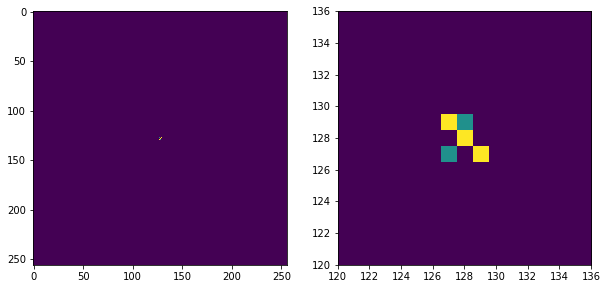

In [22]:
grid = grid_candidates(cands, 'count')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

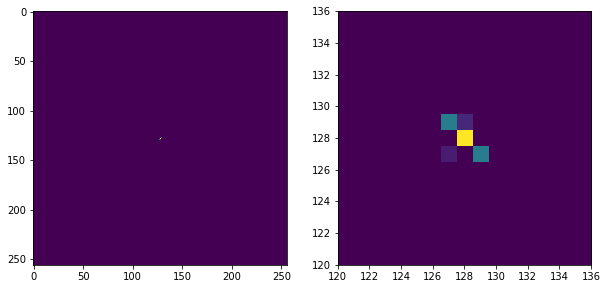

In [23]:
grid = grid_candidates(cands, 'snr')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

In [24]:
mainbuf = p.copy_mainbuf()

(664, 186, 11, 256, 8, 2)


' max/min/mean/rms/sum/S/N = 3.20e+01/0.00e+00/2.31e-01/4.98e-01/1.10e+04/64.3 peak at (0, 0)'

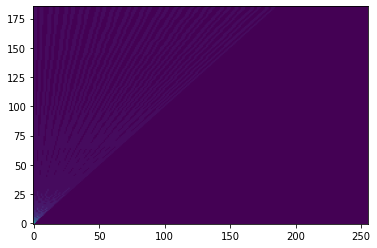

In [25]:
print(mainbuf.shape)
# look at the DM-time plan for UV 0
d = mainbuf[0,:,0,:,0,0]
imshow(d, aspect='auto', origin='lower')
printstats(d)

(664, 8, 256)
(5312, 256)


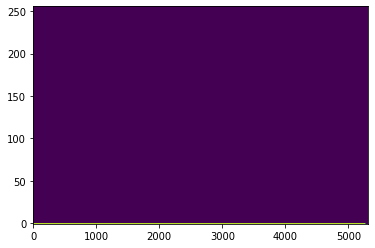

In [26]:
# look at DM=0 for all UVs
d = mainbuf[:,0,0,:,:,0].transpose([0,2,1])
print(d.shape)
d = d.reshape(d.shape[0]*d.shape[1], d.shape[2])
print(d.shape)

imshow(d.T, aspect='auto', origin='lower')

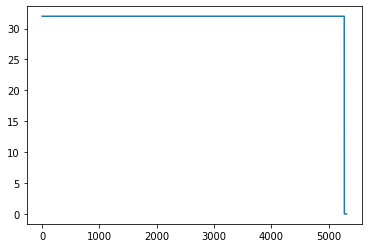

In [27]:
plot(d[:, 0])
 # Oh yeah, OK, this makes sense. It's 32 for all baselines because I made every UV = 1. IN practice, it won't be that neat.

# And what if I grid everything properly?

In [28]:
print(plan.baseline_shape) # nbl, nc, nt
values.input_scale = 1./16. # need this otherwise somewhere candidates overflow.

(190, 256, 256)


In [29]:
din = np.zeros(plan.baseline_shape, dtype=np.complex64)
din[:, :, 0] = 1 # making this 32 overflows the FDMT


In [30]:
import craft.craco
fast_baseline2uv = craft.craco.FastBaseline2Uv(plan, conjugate_lower_uvs=True)
uv_shape     = (plan.nuvrest, plan.nt, plan.ncin, plan.nuvwide)
uv_out  = np.zeros(uv_shape, dtype=np.complex64)
fast_baseline2uv(din, uv_out)

In [31]:
print(uv_out.shape)

(659, 256, 32, 8)


In [32]:
p.inbuf.nparr[:,:,:,:,0] = np.round(uv_out[:,:,:,:].real*(values.input_scale*float(1<<NBINARY_POINT_FDMTIN)))
p.inbuf.nparr[:,:,:,:,1] = np.round(uv_out[:,:,:,:].imag*(values.input_scale*float(1<<NBINARY_POINT_FDMTIN)))
print(p.inbuf.nparr.mean())

0.001126232928679818


In [33]:
p.inbuf.copy_to_device()

In [34]:
p.run(0, values).wait()

INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Running fdmt
INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f819280c3b0>
INFO:craco.search_pipeline:Call: 1.0810361900075804 Wait:0.0010901769855991006: Total:1.0821263669931795
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f8192e645a8>
INFO:craco.search_pipeline:Call: 1.0810361900075804 Wait:0.0024867469910532236: Total:1.0835229369986337
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f8192e64420>
INFO:craco.search_pipeline:Call: 1.0810361900075804 Wait:0.004300853994209319: Total:1.0853370440017898
INFO:craco.search_pipeline:Waiting for istart=3 sta

In [35]:
mainbuf = p.copy_mainbuf()

(664, 186, 11, 256, 8, 2)


' max/min/mean/rms/sum/S/N = 6.40e+01/0.00e+00/4.62e-01/9.96e-01/2.20e+04/64.3 peak at (0, 0)'

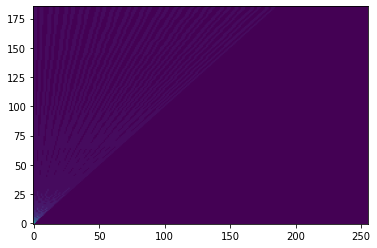

In [36]:
print(mainbuf.shape)
# look at the DM-time plan for UV 0
d = mainbuf[0,:,0,:,0,0]
imshow(d, aspect='auto', origin='lower')
printstats(d)

(664, 8, 256)
(5312, 256)


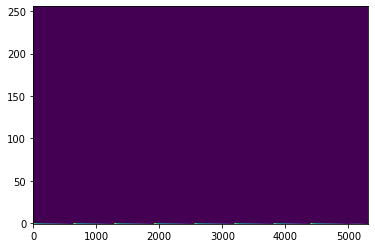

In [37]:
# look at DM=0 for all UVs
d = mainbuf[:,0,0,:,:,0].transpose([0,2,1])
print(d.shape)
d = d.reshape(d.shape[0]*d.shape[1], d.shape[2])
print(d.shape)

imshow(d.T, aspect='auto', origin='lower')

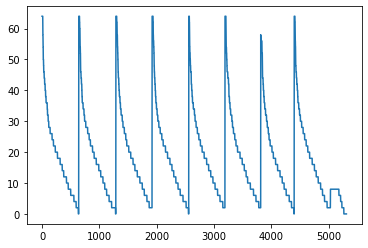

In [38]:
plot(d[:, 0])
# OK so this crazy shape is because of how we're inefficiently packing channels into UV points

In [39]:
cands = p.get_candidates()
print(len(cands))

10


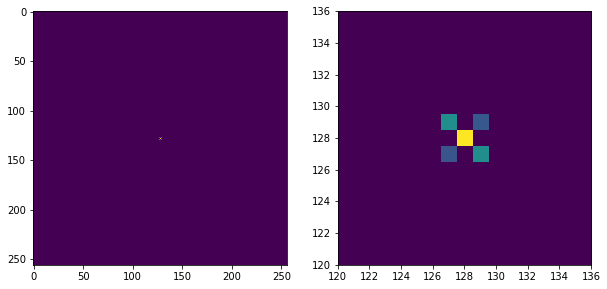

In [40]:
grid = grid_candidates(cands, 'snr')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

In [41]:
print_candidates(cands, 256, 0)

# SNR	upix	vpix	boxc_width	time	dm	iblk

47.4	128	128	0		0	0	0
13.0	129	129	1		1	0	0
23.3	127	129	0		0	0	0
23.3	129	127	0		0	0	0
12.5	127	127	0		0	0	0
47.4	128	128	0		0	1	0
13.0	129	129	1		1	1	0
23.3	127	129	0		0	1	0
23.3	129	127	0		0	1	0
12.5	127	127	0		0	1	0


# How about a DM pulse?

In [42]:
from craft import simfrb

In [43]:
dm = 5
toff = 100
tsamp = 1.7
frb = simfrb.mkfrb_fdmt(plan.fmin/1e9, plan.foff/1e9, plan.nf, tsamp, dm, toffset=toff, ntimes=plan.nt)

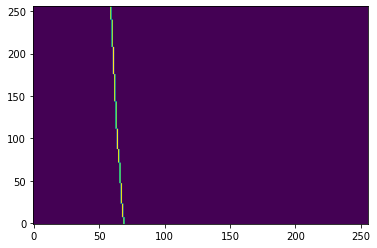

In [44]:
imshow(frb.T, aspect='auto', origin='lower')

In [45]:
din[:] = 0
print(din.shape, frb.shape)
din[:] = frb.T
fast_baseline2uv(din, uv_out)
assert din.sum() == uv_out.sum(), 'baseline2uv didnt conserve energy'

(190, 256, 256) (256, 256)


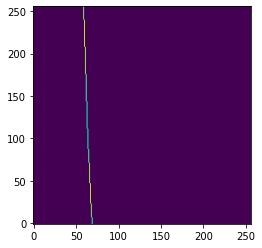

In [46]:
imshow(din[0,:,:].real, origin='lower')

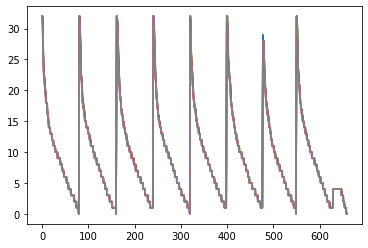

In [47]:
plot(uv_out.sum(axis=1).sum(axis=1).real)

(659, 256, 32, 8) (48640+0j) (48640+0j)


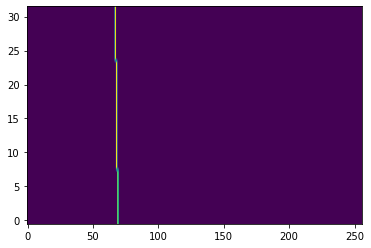

In [48]:
print(uv_out.shape, uv_out.sum(), din.sum())
imshow(uv_out[1,:,:,0].real.T, aspect='auto', origin='lower')

In [ ]:
# This one seems to hang when together with the 3 cells below. Let's space it out.
p.clear_buffers(values)


INFO:root:Clearing mainbuf data NBLK=11
INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=2 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=64 threshold=640 shift1=0 shift2=7 fft_cfg=4001c0

INFO:root:Running fdmt
INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Waiting for istart=0 start=<pyxrt.run object at 0x7f81a102cc70>
INFO:craco.search_pipeline:Call: 1.0728647310170345 Wait:0.0017536449886392802: Total:1.0746183760056738
INFO:craco.search_pipeline:Waiting for istart=1 start=<pyxrt.run object at 0x7f81a103a538>
INFO:craco.search_pipeline:Call: 1.0728647310170345 Wait:0.0037152169970795512: Total:1.076579948014114
INFO:craco.search_pipeline:Waiting for istart=2 start=<pyxrt.run object at 0x7f81a103a5e0>
INFO:craco.search_pipeline:Call:

INFO:craco.search_pipeline:Waiting for istart=4 start=<pyxrt.run object at 0x7f81a103a5e0>
INFO:craco.search_pipeline:Call: 1.0753954239771701 Wait:0.007717508997302502: Total:1.0831129329744726
INFO:craco.search_pipeline:Waiting for istart=5 start=<pyxrt.run object at 0x7f81a103a570>
INFO:craco.search_pipeline:Call: 1.0753954239771701 Wait:0.00963839702308178: Total:1.085033821000252
INFO:craco.search_pipeline:Waiting for istart=6 start=<pyxrt.run object at 0x7f81a103a688>
INFO:craco.search_pipeline:Call: 1.0753954239771701 Wait:0.011682470998493955: Total:1.087077894975664
INFO:craco.search_pipeline:Waiting for istart=7 start=<pyxrt.run object at 0x7f81a103a7a0>
INFO:craco.search_pipeline:Call: 1.0753954239771701 Wait:0.013046207022853196: Total:1.0884416310000233
INFO:craco.search_pipeline:Waiting for istart=8 start=<pyxrt.run object at 0x7f81a103a5a8>
INFO:craco.search_pipeline:Call: 1.0753954239771701 Wait:0.014004965021740645: Total:1.0894003889989108
INFO:craco.search_pipeline:W

In [ ]:

p.inbuf.nparr[:,:,:,:,0] = np.round(uv_out[:,:,:,:].real*(values.input_scale*float(1<<NBINARY_POINT_FDMTIN)))
p.inbuf.nparr[:,:,:,:,1] = np.round(uv_out[:,:,:,:].imag*(values.input_scale*float(1<<NBINARY_POINT_FDMTIN)))
p.inbuf.copy_to_device()
values.run_fdmt = True
values.run_image = True
values.threshold = 10


In [ ]:
p.run(0, values).wait()

In [ ]:
print_candidates(cands, 256, 0)

In [ ]:
grid = grid_candidates(cands, 'snr')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

In [ ]:
grid = grid_candidates(cands, 'count')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

In [ ]:
mainbuf = p.copy_mainbuf()

In [ ]:
print(mainbuf.shape)
d = mainbuf[0,:,0,:,0,0]
imshow(d, aspect='auto', origin='lower')
printstats(d)